# Filter analysis of Convolutional Layers

This notebook investigates features were learned by filters in the convolutional layers in a conv. network. Especially we are interested in the features learned by filters that show a higher average activity for inputs of a certain class. In this case the network was trained on 128 electrode EEG data to discriminate between 4 classes (right hand, left hand, rest, right foot).

To find the fiters of interest the data it was trained on (1720 trials / 430 per class) was run through the network and the average activity over all units in a filter over all inputs for a certain class was recorded. The mean activity of the filters regarding a single class was then compared with the average activity for the remaining classes to find the on average most active filters for a certain class.

The 200 trials that invoked the highest response in a unit of a filter (top 46% of class trials) were determined and the signal window that was responsible for activity in that unit (receptive field of the unit on the total input) was recorded. Several features are then extracted from those windows and their distribution is compared to a baseline of (randomly) sampled control inputs also belonging to one of the 4 classes.

The deeper the layer in the convolutional network, the bigger the receptive field of its units and more complex characteristic features are expected.

<b>In this notebook class 2 (rest) is compared to the other classes</b>

In [9]:
cl = 2
max_baseline_inputs = 5000 # Number of signal windows used for baseline
wins_per_input = 3

In [1]:
import numpy as np
import scipy
import random

import logging
log = logging.getLogger()
log.setLevel("DEBUG")
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

import sys
sys.path.append("/home/hartmank/braindecode/convvisual")

from braindecode.veganlasagne.layer_util import print_layers

import os
from numpy.random import RandomState

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5005)
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import receptive_field
import analysis
import utils

In [4]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'
RF_save = receptive_field.ReceptiveFieldInputsIO()

In [5]:
rng = RandomState(98787)

In [6]:
# Plotting functions
def cut_input_data(RF_data,filt,separated_channels=True,use_class_start_samples=False):
    reshape_channels = n_chans
    if separated_channels:
        reshape_channels = 1
    
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    filt_input_indeces = max_units_in_filters[:,1]==filt
    max_units_in_filters = max_units_in_filters[filt_input_indeces]
    
    X_RF_cropped = utils.get_cropped_RF(RF_data.results[cl].RF_X[filt_input_indeces].squeeze(),([0],reshape_channels,-1))
    window_indeces = np.unique(max_units_in_filters[:,2])
    
    classes = RF_data.classes
    neg_classes = np.delete(classes,cl)
    inputs_baseline = np.array([])
    for c in neg_classes:
        inputs_baseline = np.vstack([inputs_baseline,RF_data.results[c].inputs]) if inputs_baseline.size else RF_data.results[c].inputs
        
    print inputs_baseline.shape
    if use_class_start_samples:
        X_baseline = utils.cut_ind_windows(inputs_baseline,X_RF_cropped.shape[2],window_indeces,wins_per_input=wins_per_input).squeeze()
    else:
        X_baseline = utils.cut_rand_windows(inputs_baseline,X_RF_cropped.shape[2],wins_per_input).squeeze()
    
    if separated_channels:
        X_baseline = X_baseline.reshape((-1,X_RF_cropped.shape[1],X_RF_cropped.shape[2]))
    print X_baseline.shape
    indx = rng.permutation(len(X_baseline))[:max_baseline_inputs]
    X_baseline = X_baseline[indx]
    
    return X_RF_cropped,X_baseline 
    

def plot_max_filters(RF_data):
    print 'Max filters: ',RF_data.results[cl].max_filters
    plt.figure()
    sns.heatmap(np.reshape(RF_data.results[cl].filters_means,(-1,1)).T,
                linewidths=.5)
    plt.xlabel('Filter #')
    plt.ylabel('Activation Diff')
    plt.title('Mean activation for feature maps over all inputs')
    plt.show()
    
    
def print_features(score,p,labels,indeces):
    for idx in indeces:
        print 'Score %f  p %f  : %s'%(score[idx],p[idx],labels[idx])
        
        
def plot_RF_starts(RF_data,win_size):
    plt.figure()
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    max_units_in_filters = max_units_in_filters[max_units_in_filters[:,1]==filt]
    sns.distplot(max_units_in_filters[:,2],bins=np.arange(0,RF_data.results[cl].inputs.shape[2],20),kde=False)
    plt.xlim([1,RF_data.results[cl].inputs.shape[2]-win_size])
    plt.xlabel('Sample #')
    plt.ylabel('Number of receptive fields starting at sample')
    plt.title('Starting of the RF windows in complete input signal')
    plt.show()
    
    
def plot_channels(RF_data,sensor_names):
    max_units_in_filters = np.asarray(RF_data.results[cl].max_units_in_filters)
    max_units_in_filters = max_units_in_filters[max_units_in_filters[:,1]==filt]
    chan_counts = np.bincount(max_units_in_filters[:,3])
    max_chan = chan_counts.argmax()
    max_name = sensor_names[max_chan]
    plt.figure(figsize=(10, 10))
    sns.distplot(max_units_in_filters[:,3],bins=np.arange(n_chans),kde=False)
    plt.xlim([0,n_chans])
    plt.ylabel('Number of times signal window originated in channel')
    plt.xlabel('Channel')
    plt.title('Channels that provided maximized input %s: %d'%(max_name,chan_counts[max_chan]))
    plt.xticks(range(1,len(sensor_names)+1),sensor_names,rotation=90,fontsize=5)
    plt.show()
        
        
def plot_channel_avg(X_RF_cropped,channel,title=''):
    plt.figure()
    sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_points")
    m = X_RF_cropped[:,channel].mean(axis=0)
    s = X_RF_cropped[:,channel].std(axis=0)
    plt.fill_between(np.arange(X_RF_cropped.shape[2]),m-s,m+s,color='r',zorder=100,alpha=0.3) 
    plt.plot(np.arange(X_RF_cropped.shape[2]),m,color='r',zorder=101) 
    plt.xlabel('Sample # (250Hz)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()
    

def plot_channel_avg_comparison(X1,X2,channel):
    plt.figure()
    #sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_traces")
    sns.tsplot(data=X1[:,channel],err_style="unit_traces")
    sns.tsplot(data=X2[:,channel],err_style="unit_traces")
    plt.show()
    
    
def plot_dist_comparison(features,features_base,idx):
    sns.distplot(features[:,idx],label='Input')
    sns.distplot(features_base[:,idx],label='Baseline')
    plt.legend()
    plt.xlabel(labels[idx])
    plt.show()
    
    
def subplots_4_features(features,features_base,indeces):
    plt.figure()
    plt.subplot(221)
    plot_dist_comparison(features,features_base,indeces[0])
    plt.subplot(222)
    plot_dist_comparison(features,features_base,indeces[1])
    plt.subplot(223)
    plot_dist_comparison(features,features_base,indeces[2])
    plt.subplot(224)
    plot_dist_comparison(features,features_base,indeces[3])
    
    
def plot_phaselocks(phaselocks,sensor_names):
    plt.figure(figsize=(30, 30))
    sns.heatmap(phaselocks,xticklabels=sensor_names,yticklabels=sensor_names)
    plt.plot([0, len(sensor_names)],[len(sensor_names), 0])
    plt.show()

# Layer 03

Analysis of filters in Layer 03

In [8]:
filename = 'Layer03_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_03 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [13 20 22  2 18]


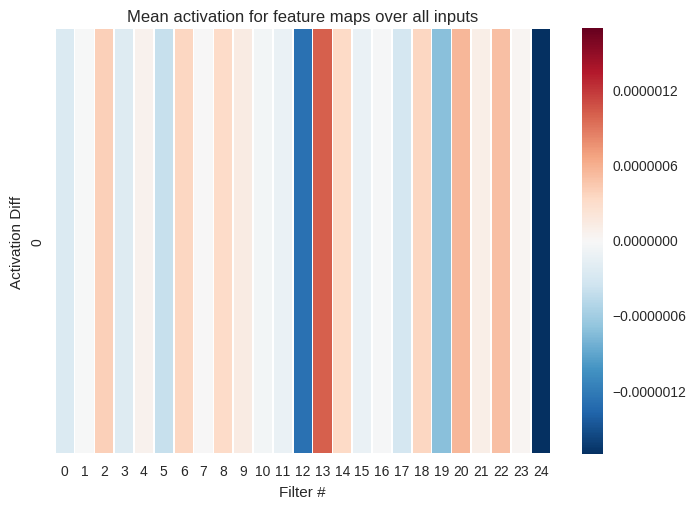

In [9]:
plot_max_filters(RF_data_03)

<b>Filter to look at</b> (index in Max filters)

In [10]:
filt = 0

In [11]:
n_chans = RF_data_03.results[cl].n_chans
sampling_rate = RF_data_03.results[cl].sampling_rate
sensor_names = RF_data_03.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_03,filt,separated_channels=True)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

sensor_names_one_chan = ['N/A' for entry in sensor_names]
feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names_one_chan,frequencies],
                                    'FFTc':[sensor_names_one_chan,frequencies],
                                    'Phase':[sensor_names_one_chan,frequencies[1:]],
                                    'Phasec':[sensor_names_one_chan,frequencies[1:]],
                                    'Mean':[sensor_names_one_chan],
                                    'Meanc':[sensor_names_one_chan],
                                    'Bandpower':[sensor_names_one_chan]})

(1344, 128, 1000, 1)
(516096, 1, 10)
(200, 1, 5) (200, 1) (200, 1, 1) (200, 1)
(5000, 1, 5) (5000, 1) (5000, 1, 1) (5000, 1)


utils.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp = inputs[i,:,ind_start[i,j]:ind_end[i,j]]


In [12]:
print X_RF_cropped.shape

(200, 1, 10)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

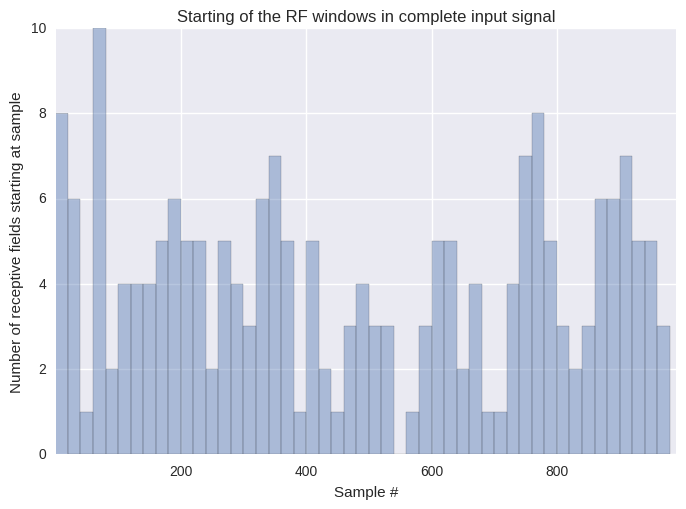

In [13]:
plot_RF_starts(RF_data_03,X_baseline.shape[2])

### Channels of the Receptive Field
In Layer 03 the receptive field is still channel specific. Therefore it could be interesting to see from which channel the most maximizing signal windows originate

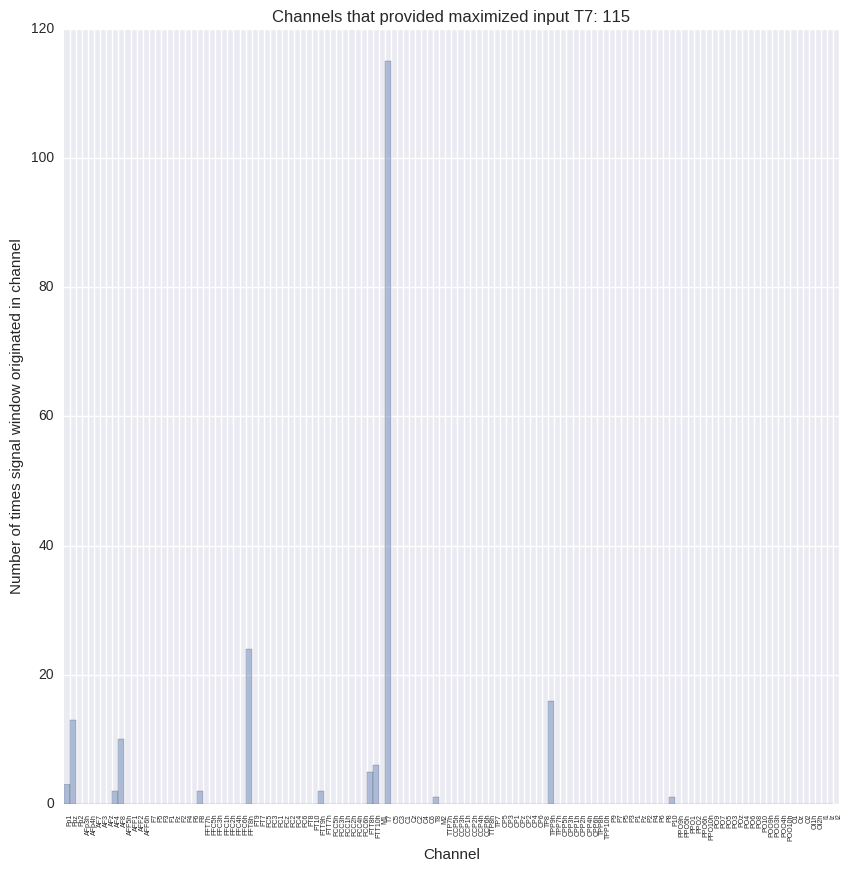

In [14]:
plot_channels(RF_data_03,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

There are no channel specific features in L03, because the features are extracted for the one channel in the receptive field.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [15]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.997800  p 0.000000  : Bandpower N/A
Score 0.990200  p 0.000000  : FFT N/A 75.0
Score 0.962400  p 0.000000  : FFT N/A 50.0
Score 0.953400  p 0.000000  : FFT N/A 100.0
Score 0.882000  p 0.000000  : FFT N/A 25.0
Score 0.773200  p 0.000000  : Meanc N/A
Score 0.744000  p 0.000000  : FFTc N/A 25.0
Score 0.623800  p 0.000000  : Phase N/A 25.0
Score 0.599400  p 0.000000  : Phase N/A 75.0
Score 0.487200  p 0.000000  : Phase N/A 50.0
Score 0.443000  p 0.000000  : Phase N/A 100.0
Score 0.252000  p 0.000000  : FFTc N/A 0.0
Score 0.250600  p 0.000000  : Phasec N/A 25.0
Score 0.197600  p 0.000000  : Mean N/A
Score 0.132200  p 0.002126  : FFT N/A 0.0


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

(200, 15) (5000, 15)


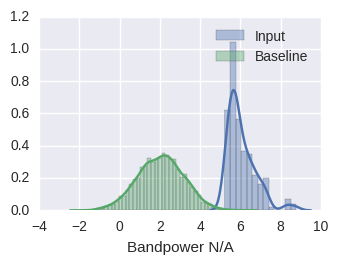

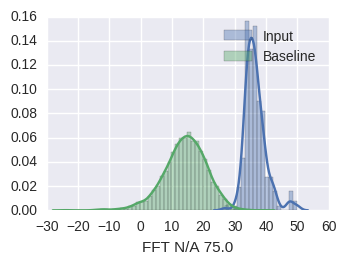

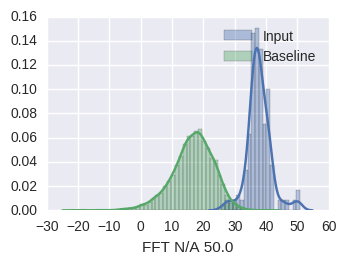

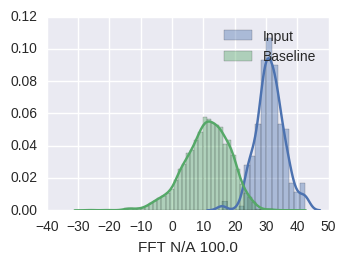

In [16]:
print features_class.shape,features_base.shape
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

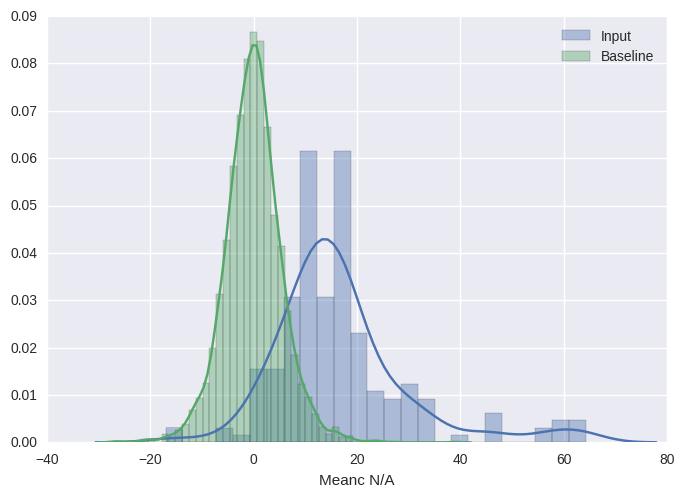

In [17]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[5])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows.  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [18]:
print index_labels[sort_mean_diff[:10]]

[['Bandpower', [0]] ['FFT', [0, 3]] ['FFT', [0, 2]] ['FFT', [0, 4]]
 ['FFT', [0, 1]] ['Meanc', [0]] ['FFTc', [0, 1]] ['Phase', [0, 0]]
 ['Phase', [0, 2]] ['Phase', [0, 1]]]


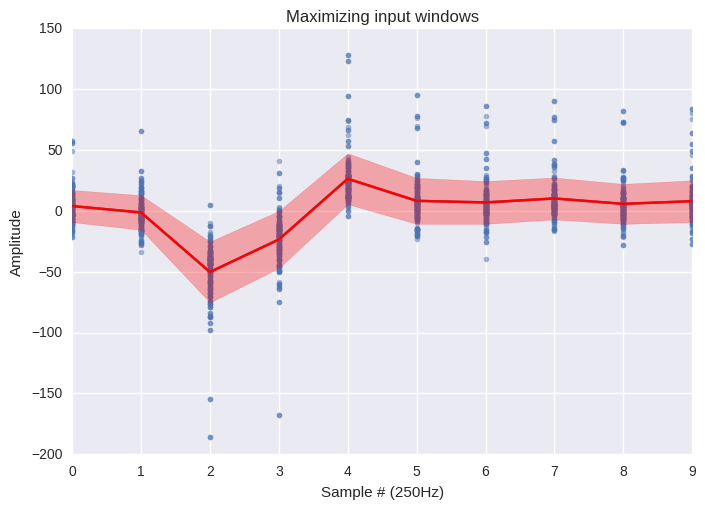

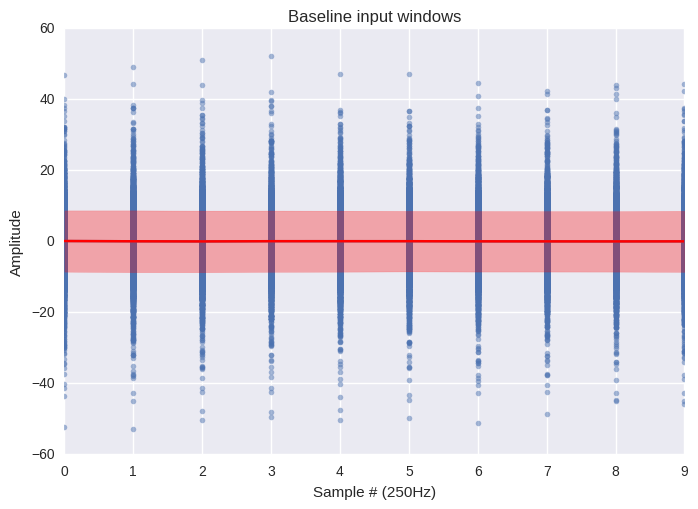

In [19]:
plot_channel_avg(X_RF_cropped,0,'Maximizing input windows')
plot_channel_avg(X_baseline,0,'Baseline input windows')

# Layer 04

Analysis of filters in Layer 04

In [20]:
del RF_data_03

In [7]:
filename = 'Layer04_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_04 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [ 7  1  2 22 19]


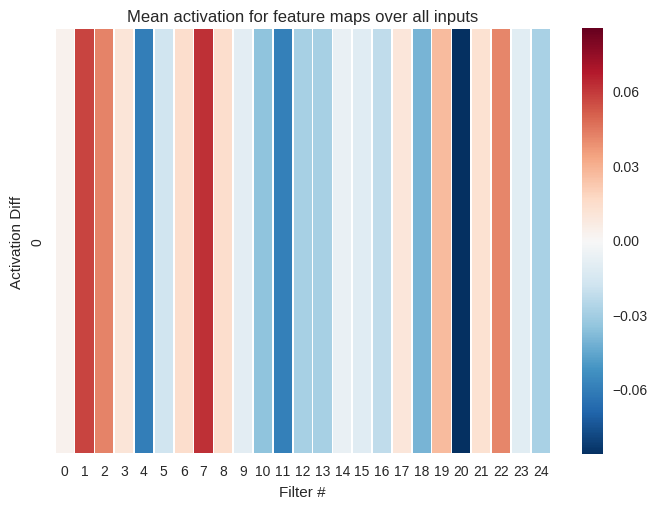

In [22]:
plot_max_filters(RF_data_04)

<b>Filter to look at</b> (index in Max filters)

In [10]:
filt = 0

In [11]:
n_chans = RF_data_04.results[cl].n_chans
sampling_rate = RF_data_04.results[cl].sampling_rate
sensor_names = RF_data_04.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_04,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1344, 128, 1000, 1)
(4032, 128, 10)


/home/hartmank/braindecode/convvisual/utils.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp = inputs[i,:,ind_start[i,j]:ind_end[i,j]]


(200, 128, 5) (200, 128) (200, 128, 1) (200, 128)
(4032, 128, 5) (4032, 128) (4032, 128, 1) (4032, 128)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

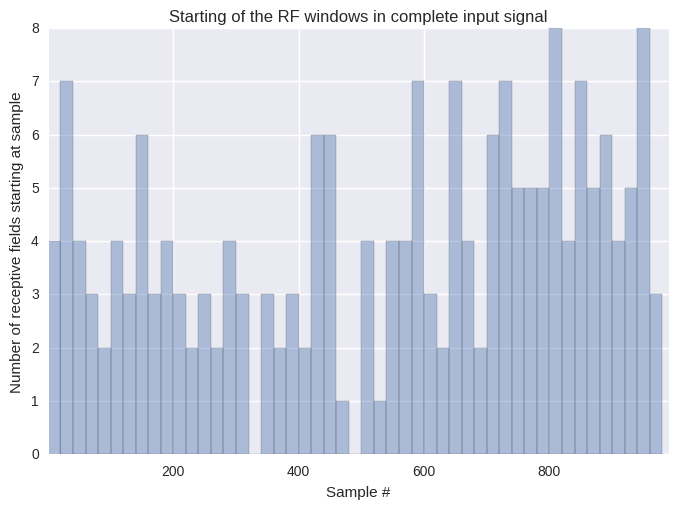

In [25]:
plot_RF_starts(RF_data_04,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


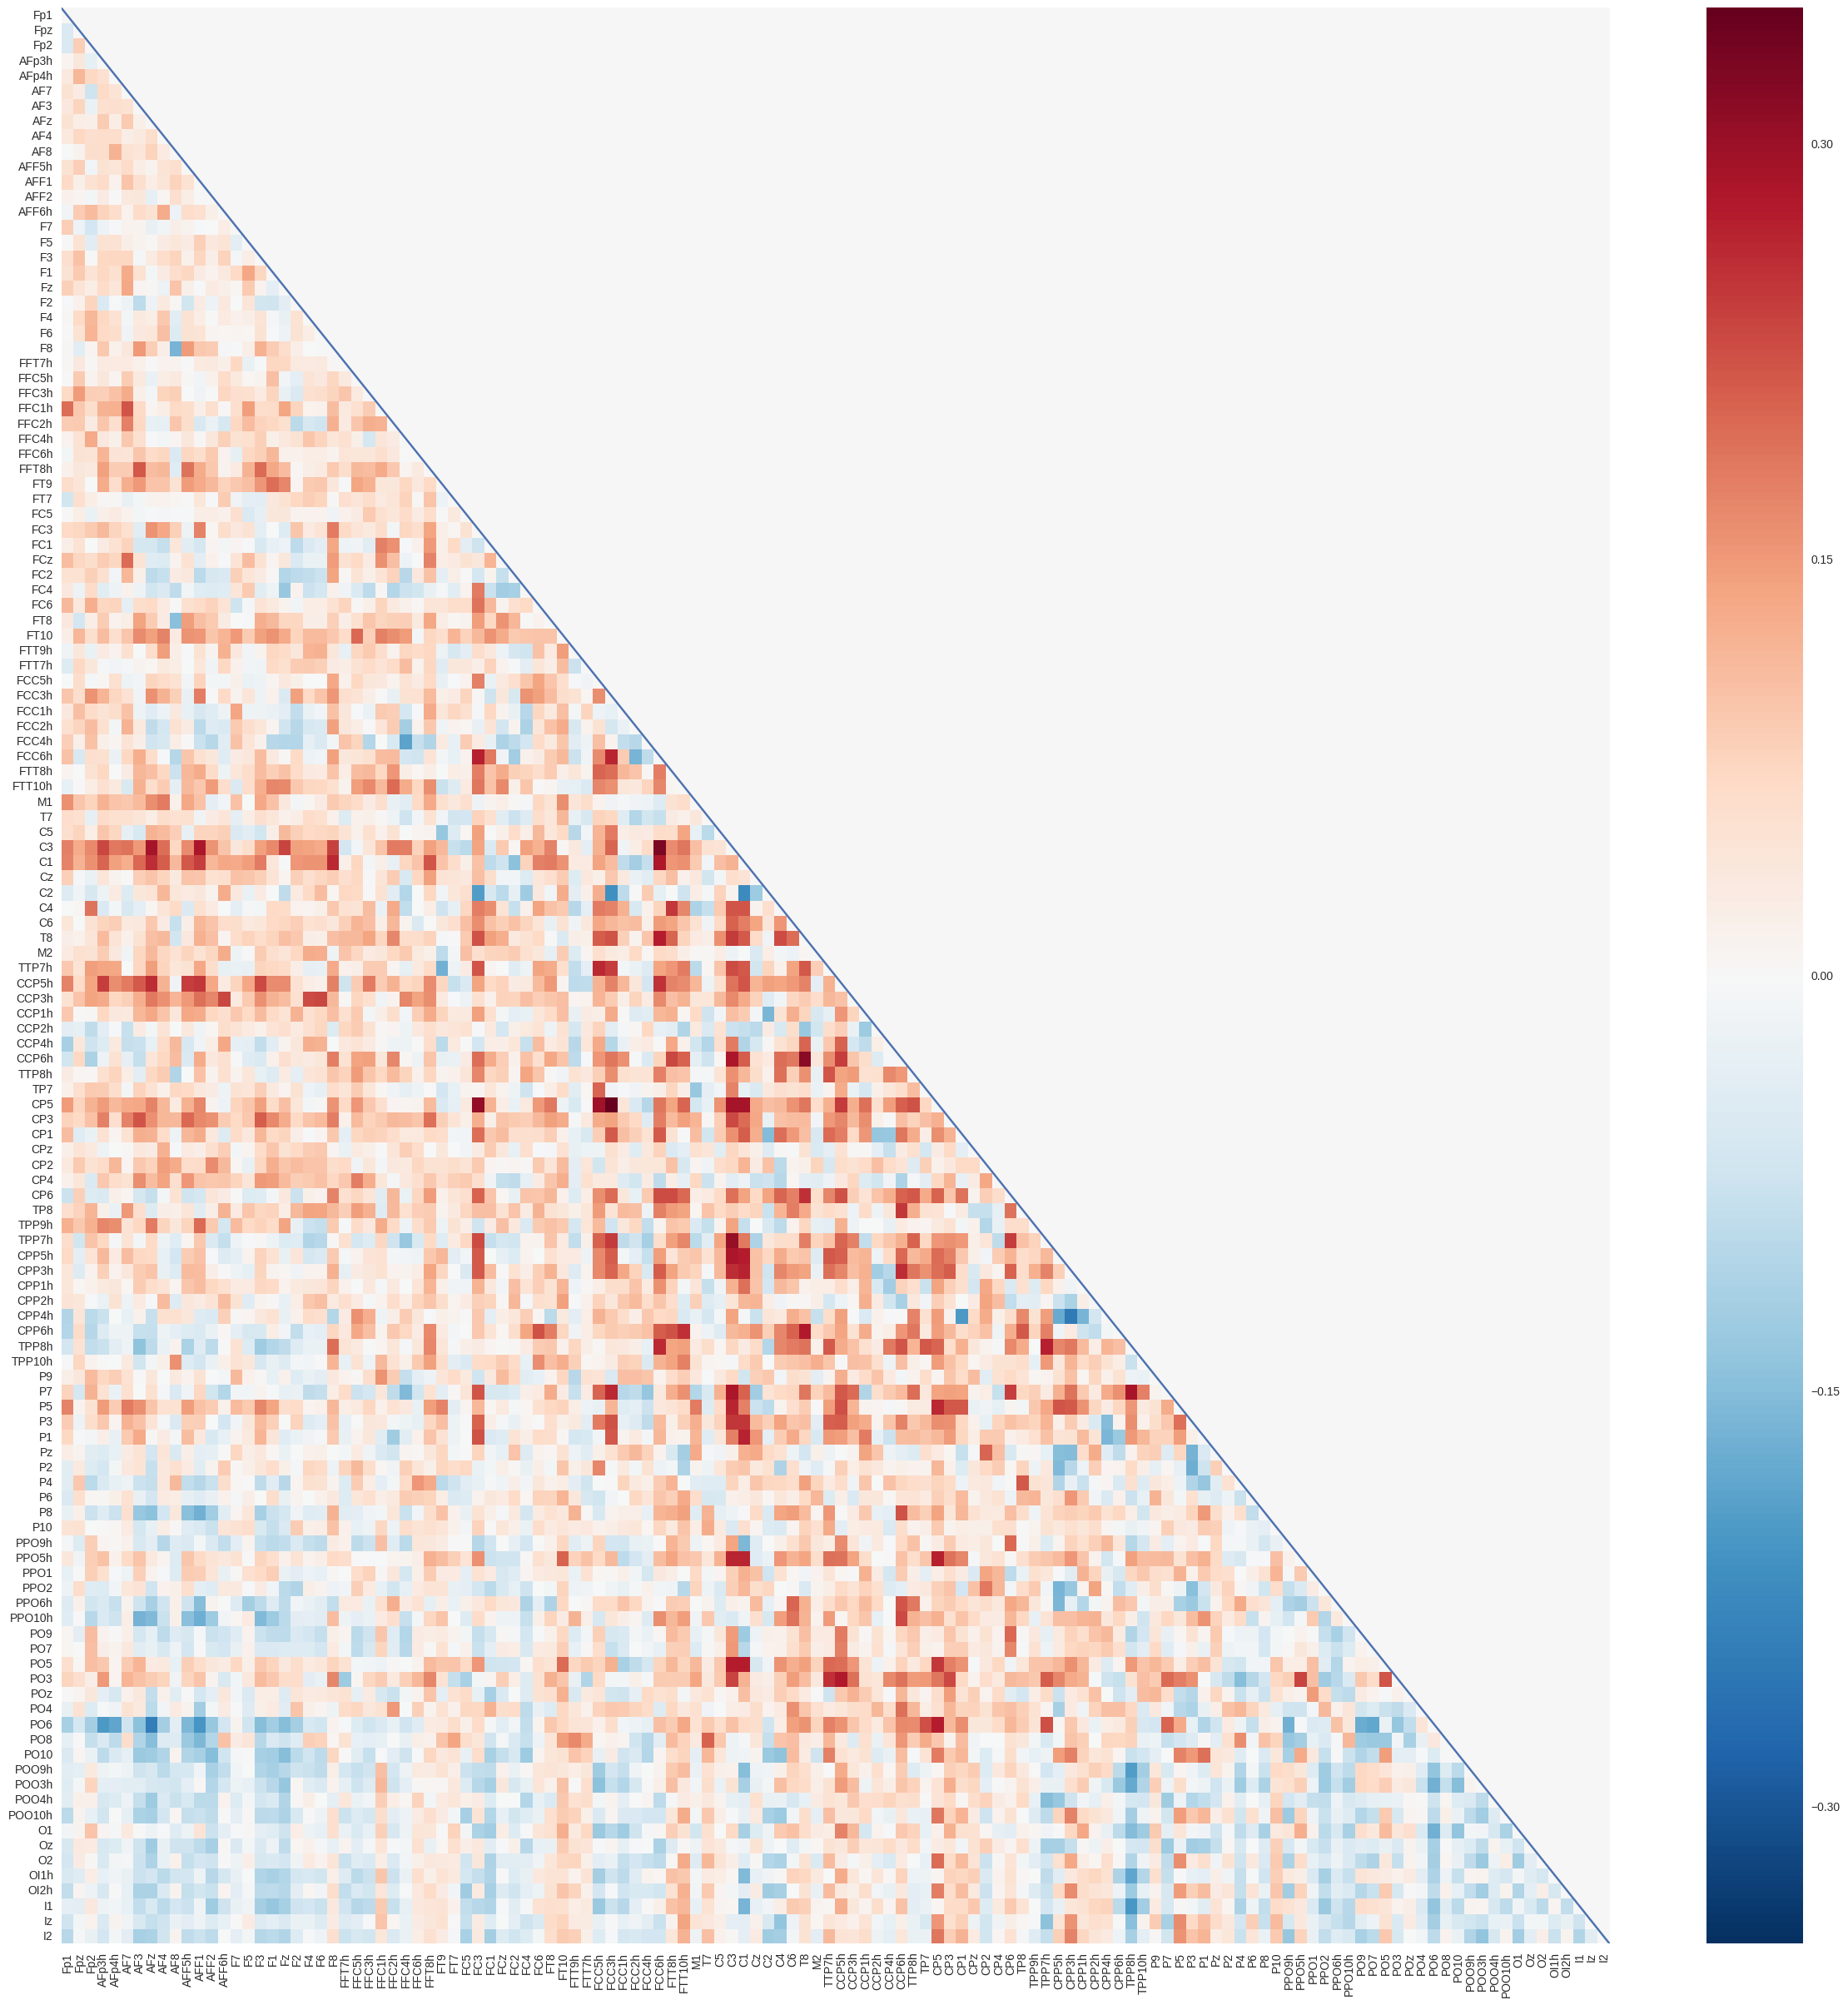

In [26]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [27]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.760804  p 0.000000  : Meanc CCP5h
Score 0.741567  p 0.000000  : Meanc C3
Score 0.735129  p 0.000000  : Meanc CP5
Score 0.713631  p 0.000000  : Bandpower CCP5h
Score 0.685714  p 0.000000  : Meanc CP3
Score 0.681895  p 0.000000  : Bandpower CP5
Score 0.675000  p 0.000000  : FFT CCP5h 25.0
Score 0.661181  p 0.000000  : Meanc CCP3h
Score 0.656647  p 0.000000  : Meanc C5
Score 0.640069  p 0.000000  : Bandpower C3
Score 0.629296  p 0.000000  : FFT CP5 25.0
Score 0.627986  p 0.000000  : Meanc P5
Score 0.622034  p 0.000000  : FFT CP3 25.0
Score 0.620079  p 0.000000  : Meanc TTP7h
Score 0.619762  p 0.000000  : Bandpower CP3
Score 0.615962  p 0.000000  : FFT C3 75.0
Score 0.615526  p 0.000000  : FFT CCP5h 100.0
Score 0.614504  p 0.000000  : FFT C3 25.0
Score 0.614454  p 0.000000  : FFT CCP5h 75.0
Score 0.613800  p 0.000000  : Meanc CPP3h


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

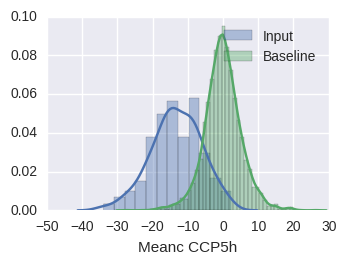

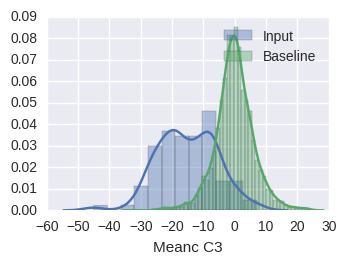

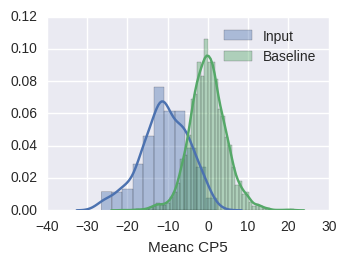

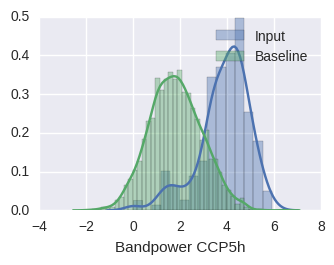

In [28]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

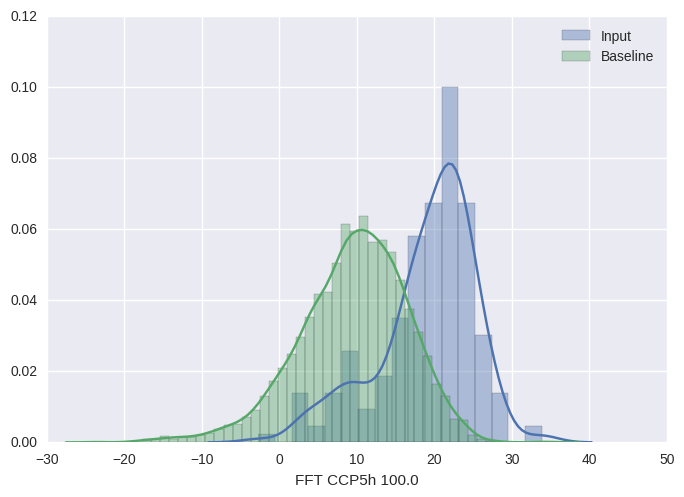

In [29]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[16])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [30]:
print index_labels[sort_mean_diff[:10]]

[['Meanc', [64]] ['Meanc', [55]] ['Meanc', [72]] ['Bandpower', [64]]
 ['Meanc', [73]] ['Bandpower', [72]] ['FFT', [64, 1]] ['Meanc', [65]]
 ['Meanc', [54]] ['Bandpower', [55]]]


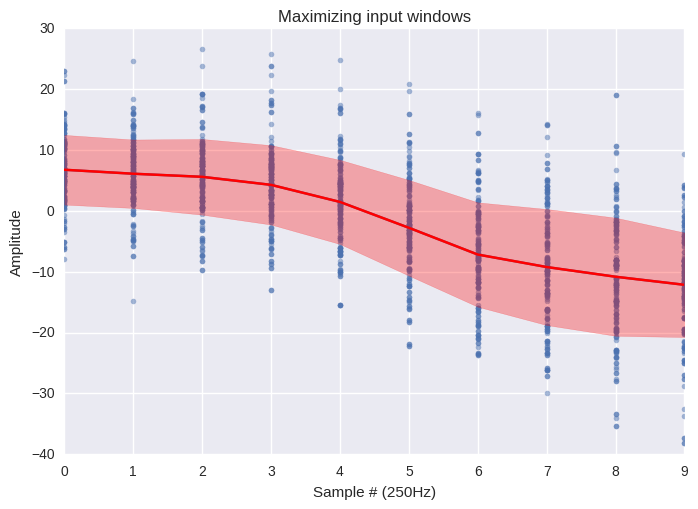

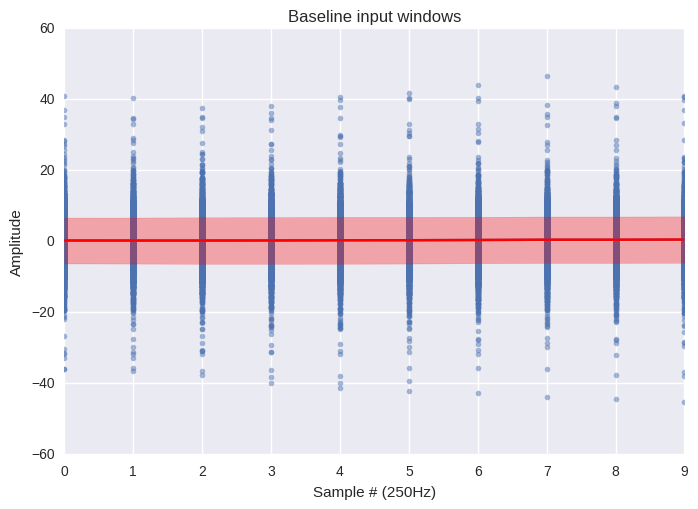

In [12]:
plot_channel_avg(X_RF_cropped,64,'Maximizing input windows')
plot_channel_avg(X_baseline,64,'Baseline input windows')

# Layer 10

Analysis of filters in Layer 10

In [13]:
del RF_data_04

In [14]:
filename = 'Layer10_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_10 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [ 4 22  7 48  9]


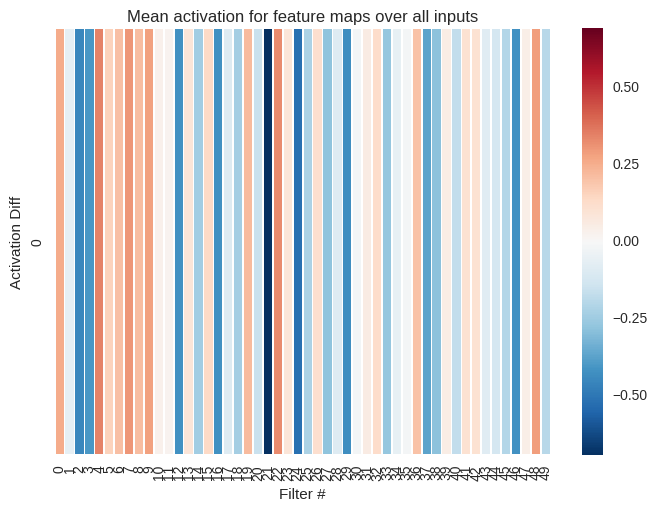

In [34]:
plot_max_filters(RF_data_10)

<b>Filter to look at</b> (index in Max filters)

In [35]:
filt = 0

In [15]:
n_chans = RF_data_10.results[cl].n_chans
sampling_rate = RF_data_10.results[cl].sampling_rate
sensor_names = RF_data_10.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_10,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1344, 128, 1000, 1)
(4032, 128, 39)
(200, 128, 19) (200, 128) (200, 128, 8) (200, 128)
(4032, 128, 19) (4032, 128) (4032, 128, 8) (4032, 128)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

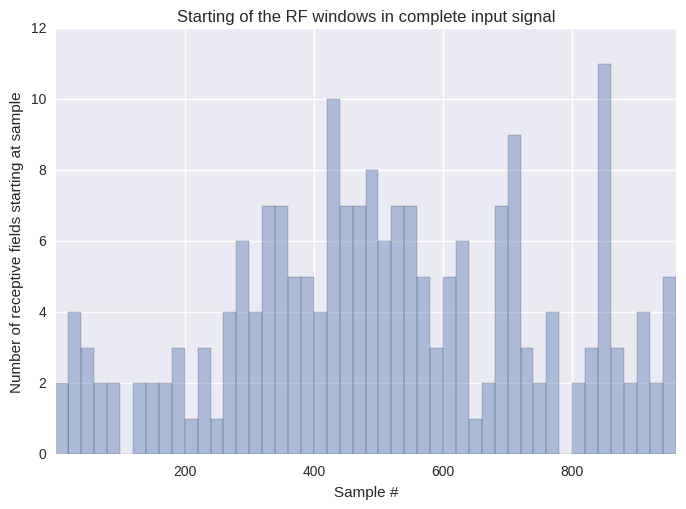

In [37]:
plot_RF_starts(RF_data_10,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

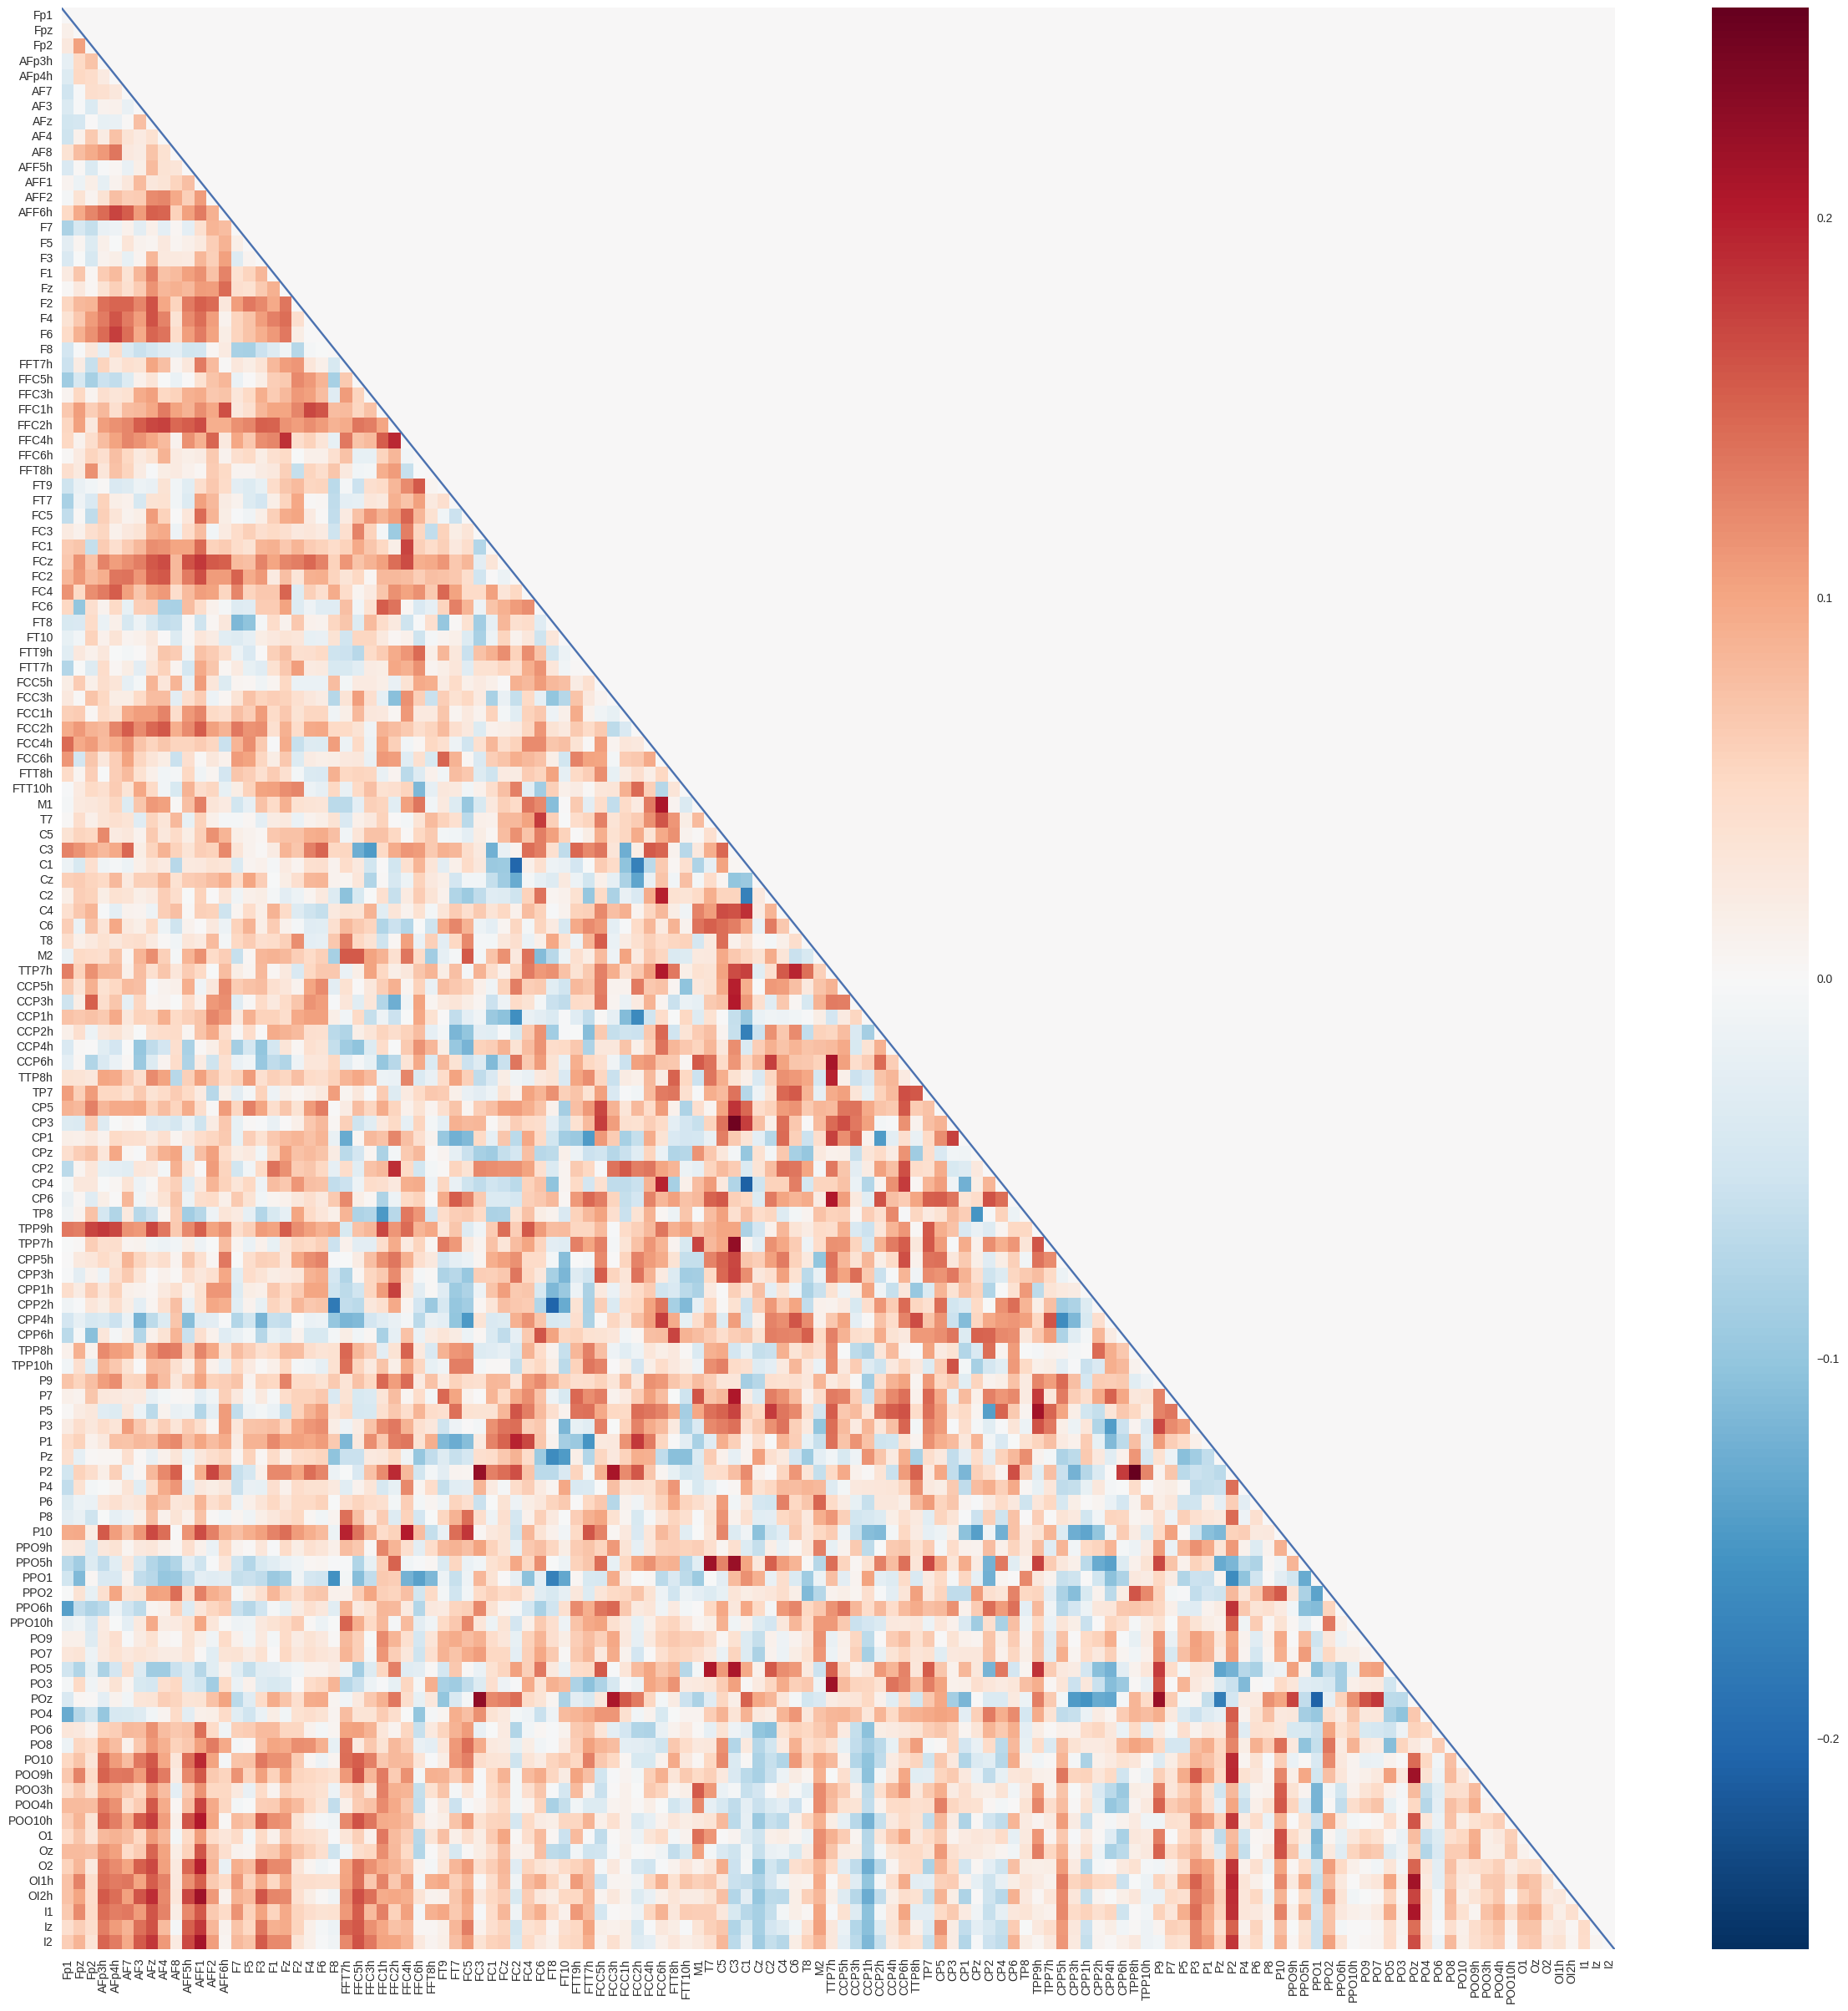

In [38]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [39]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.572024  p 0.000000  : FFT C3 12.8205128205
Score 0.547103  p 0.000000  : FFT CCP5h 12.8205128205
Score 0.540387  p 0.000000  : Bandpower C3
Score 0.532183  p 0.000000  : Bandpower CCP3h
Score 0.506141  p 0.000000  : Bandpower CP3
Score 0.487034  p 0.000000  : FFT CCP3h 12.8205128205
Score 0.472401  p 0.000000  : Bandpower CCP5h
Score 0.462450  p 0.000000  : FFT CP3 12.8205128205
Score 0.450635  p 0.000000  : FFT CCP3h 25.641025641
Score 0.436994  p 0.000000  : FFT CCP3h 32.0512820513
Score 0.432500  p 0.000000  : FFT CP5 12.8205128205
Score 0.426310  p 0.000000  : Bandpower C1
Score 0.421627  p 0.000000  : Phase C3 12.8205128205
Score 0.412103  p 0.000000  : Bandpower CCP4h
Score 0.410427  p 0.000000  : Phase CCP3h 12.8205128205
Score 0.407589  p 0.000000  : FFT C3 32.0512820513
Score 0.405456  p 0.000000  : FFT CCP1h 38.4615384615
Score 0.399563  p 0.000000  : FFT Cz 38.4615384615
Score 0.395258  p 0.000000  : Phase CCP5h 12.8205128205
Score 0.393978  p 0.000000  : FFT CP1 32.

##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

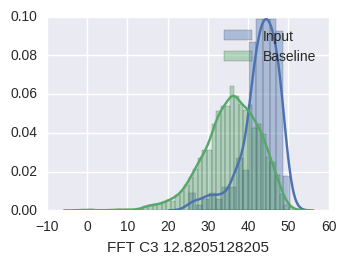

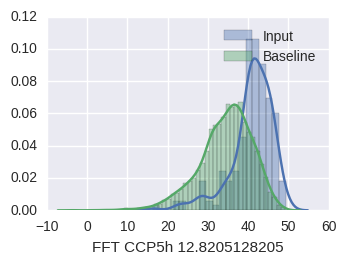

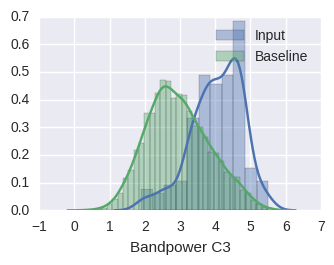

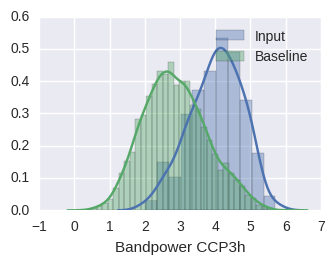

In [40]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

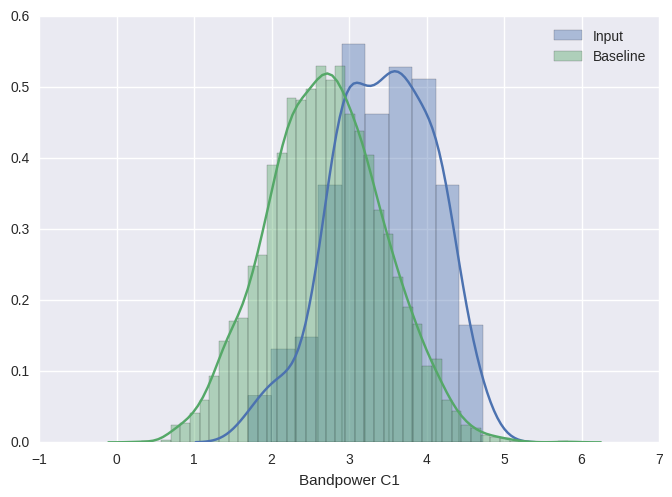

In [41]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[11])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [42]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [55, 2]] ['FFT', [64, 2]] ['Bandpower', [55]] ['Bandpower', [65]]
 ['Bandpower', [73]] ['FFT', [65, 2]] ['Bandpower', [64]] ['FFT', [73, 2]]
 ['FFT', [65, 4]] ['FFT', [65, 5]]]


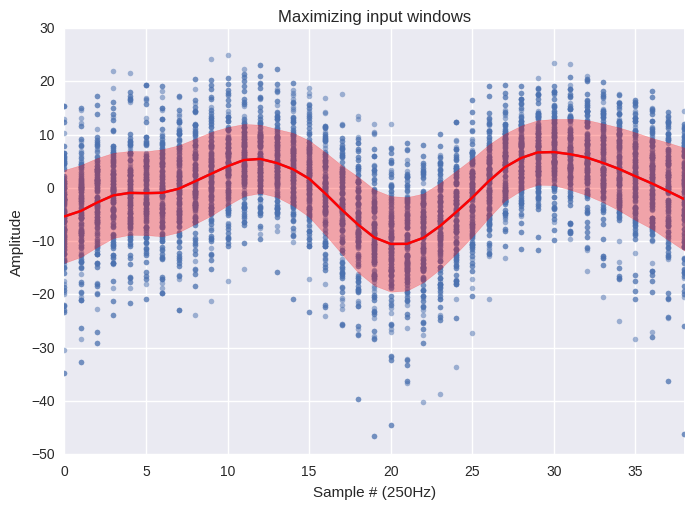

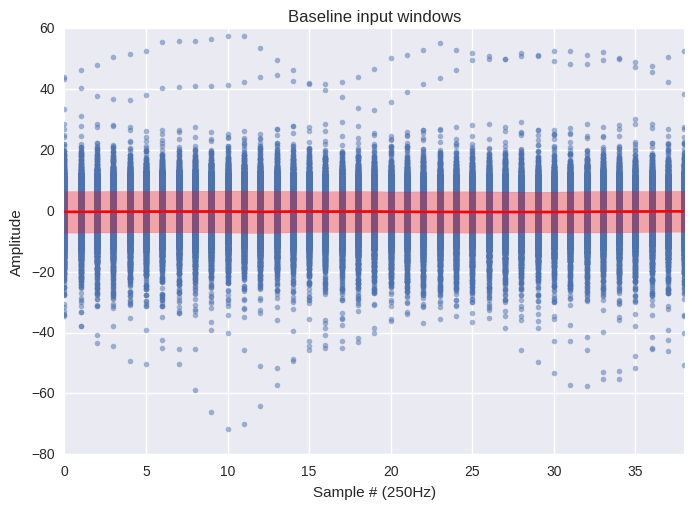

In [16]:
plot_channel_avg(X_RF_cropped,55,'Maximizing input windows')
plot_channel_avg(X_baseline,55,'Baseline input windows')

# Layer 16

Analysis of filters in Layer 16

In [17]:
del RF_data_10

In [18]:
filename = 'Layer16_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_16 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [19 69 84 29 86]


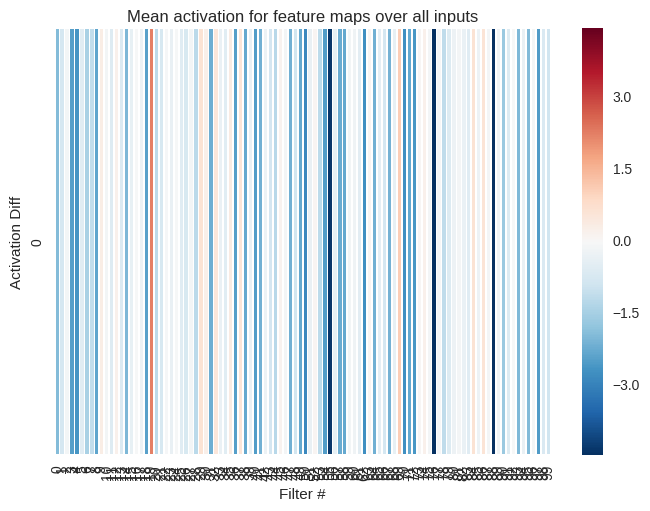

In [46]:
plot_max_filters(RF_data_16)

<b>Filter to look at</b> (index in Max filters)

In [47]:
filt = 0

In [19]:
n_chans = RF_data_16.results[cl].n_chans
sampling_rate = RF_data_16.results[cl].sampling_rate
sensor_names = RF_data_16.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_16,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1344, 128, 1000, 1)
(4032, 128, 126)
(200, 128, 63) (200, 128) (200, 128, 30) (200, 128)
(4032, 128, 63) (4032, 128) (4032, 128, 30) (4032, 128)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

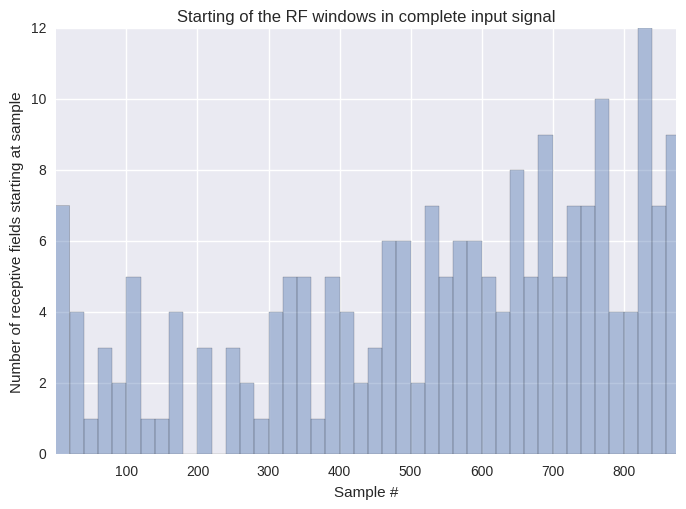

In [49]:
plot_RF_starts(RF_data_16,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

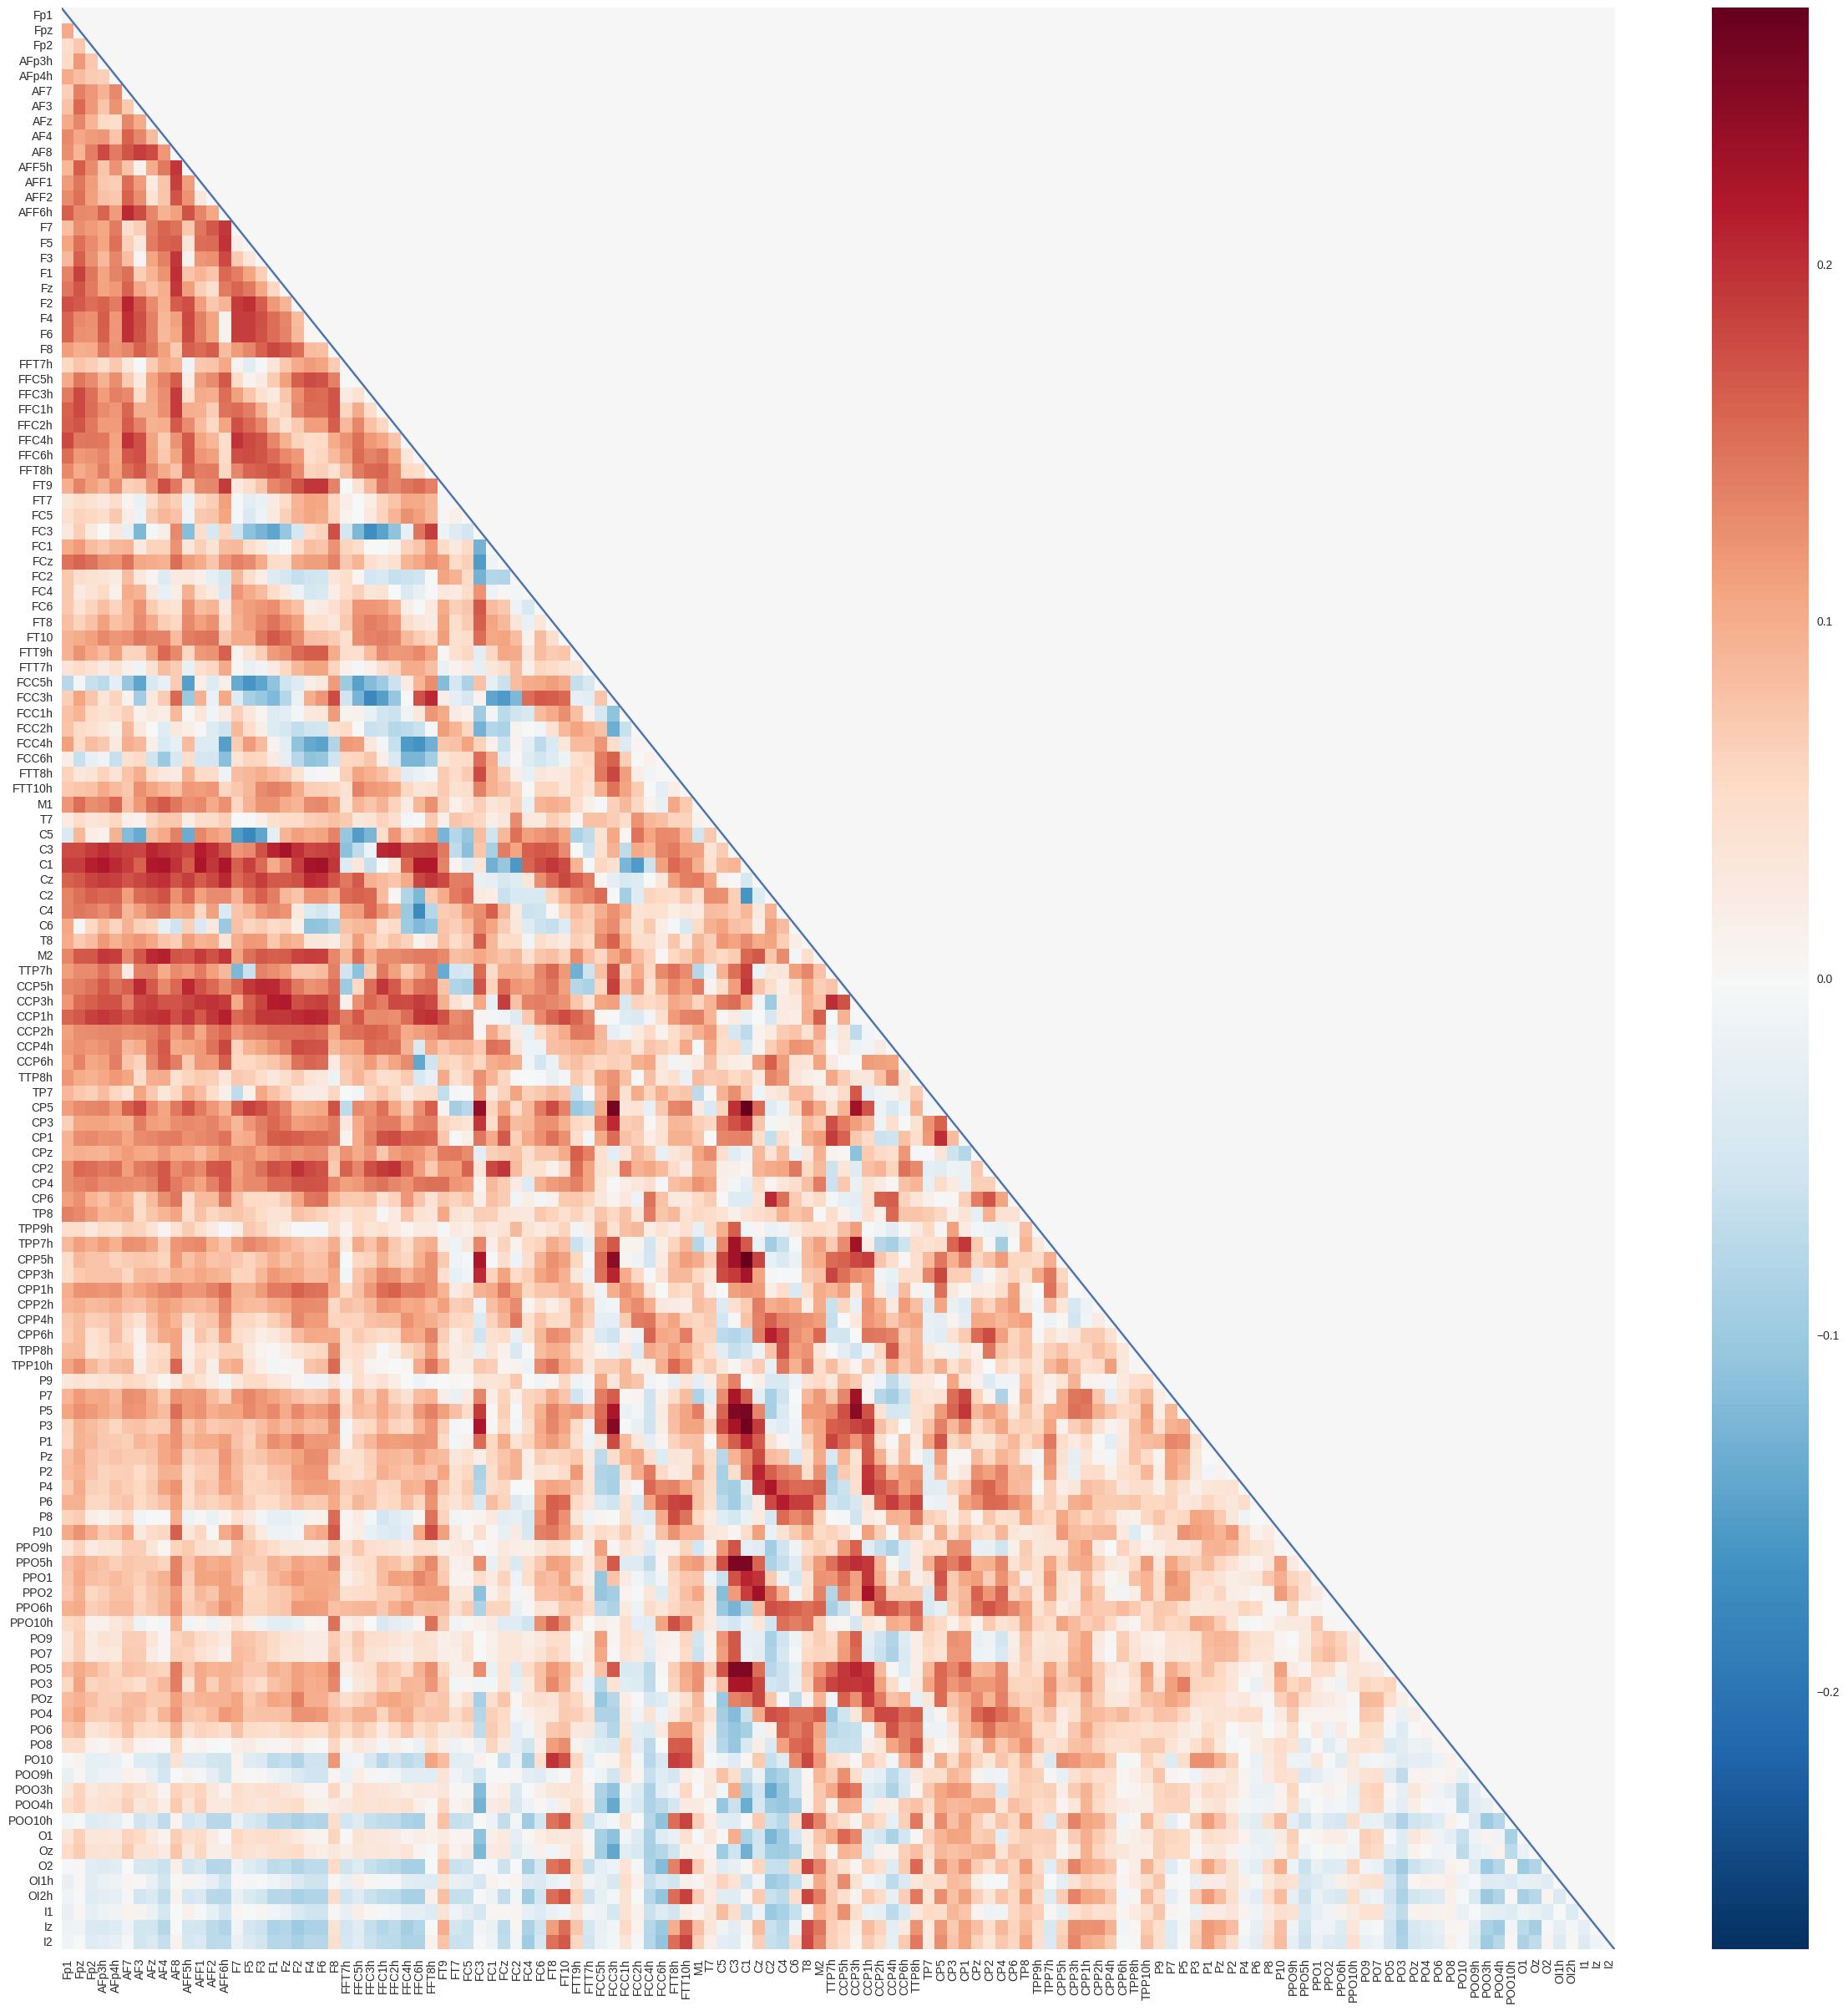

In [50]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [51]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.619266  p 0.000000  : Bandpower CCP3h
Score 0.614048  p 0.000000  : Bandpower C3
Score 0.525367  p 0.000000  : Bandpower CCP5h
Score 0.520536  p 0.000000  : Bandpower C1
Score 0.520298  p 0.000000  : Bandpower CCP2h
Score 0.508472  p 0.000000  : FFT C3 9.92063492063
Score 0.497063  p 0.000000  : Bandpower CP3
Score 0.492083  p 0.000000  : Bandpower CCP4h
Score 0.487341  p 0.000000  : Bandpower CP4
Score 0.486706  p 0.000000  : Bandpower C2
Score 0.475526  p 0.000000  : FFT C3 21.8253968254
Score 0.475030  p 0.000000  : FFT CCP3h 9.92063492063
Score 0.474841  p 0.000000  : Bandpower C4
Score 0.474623  p 0.000000  : FFT CCP3h 21.8253968254
Score 0.469970  p 0.000000  : Bandpower CP1
Score 0.466062  p 0.000000  : Bandpower FCC3h
Score 0.456647  p 0.000000  : FFT CCP3h 31.746031746
Score 0.455248  p 0.000000  : Bandpower CP5
Score 0.451468  p 0.000000  : Bandpower CPz
Score 0.450744  p 0.000000  : FFT CP3 9.92063492063


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

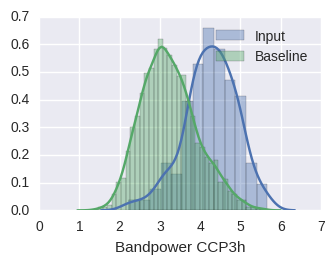

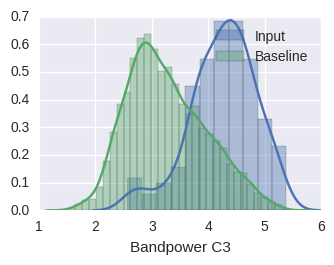

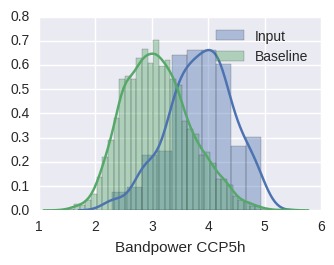

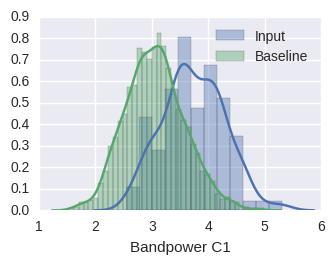

In [52]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

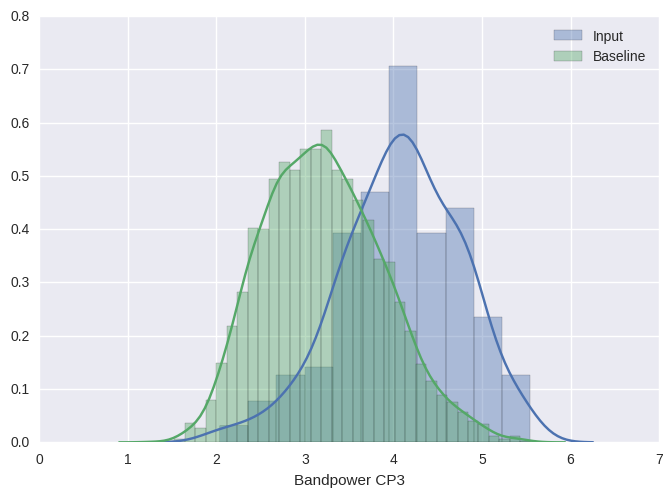

In [53]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[6])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [54]:
print index_labels[sort_mean_diff[:10]]

[['Bandpower', [65]] ['Bandpower', [55]] ['Bandpower', [64]]
 ['Bandpower', [56]] ['Bandpower', [67]] ['FFT', [55, 5]]
 ['Bandpower', [73]] ['Bandpower', [68]] ['Bandpower', [77]]
 ['Bandpower', [58]]]


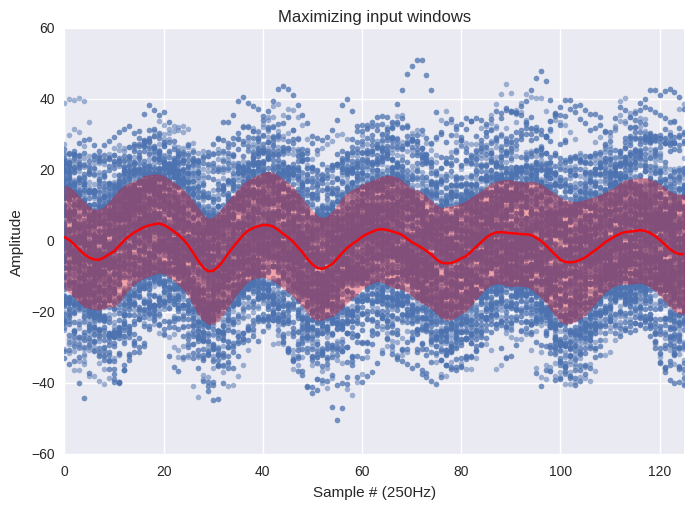

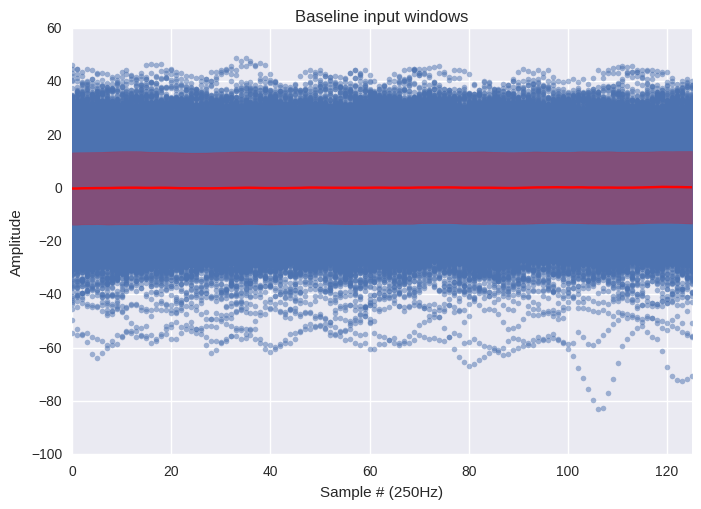

In [20]:
plot_channel_avg(X_RF_cropped,65,'Maximizing input windows')
plot_channel_avg(X_baseline,65,'Baseline input windows')

# Layer 22

Analysis of filters in Layer 22

In [21]:
del RF_data_16

In [22]:
filename = 'Layer22_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_22 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [ 59  42  26 135 158]


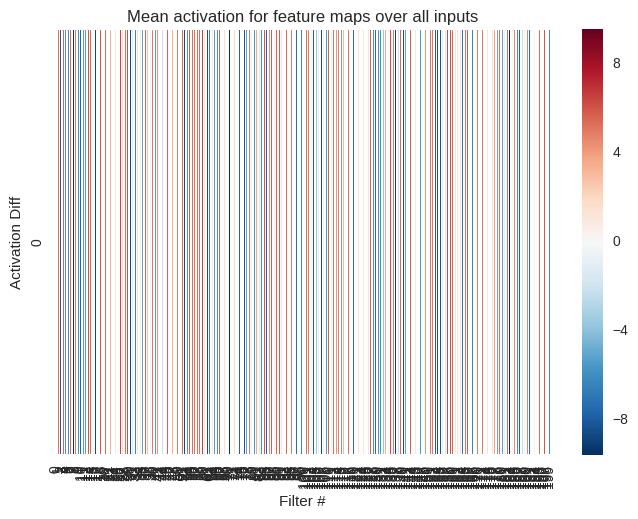

In [58]:
plot_max_filters(RF_data_22)

<b>Filter to look at</b> (index in Max filters)

In [59]:
filt = 0

In [60]:
n_chans = RF_data_22.results[cl].n_chans
sampling_rate = RF_data_22.results[cl].sampling_rate
sensor_names = RF_data_22.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_22,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1344, 128, 1000, 1)
(4032, 128, 387)
(200, 128, 193) (200, 128) (200, 128, 95) (200, 128)
(4032, 128, 193) (4032, 128) (4032, 128, 95) (4032, 128)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

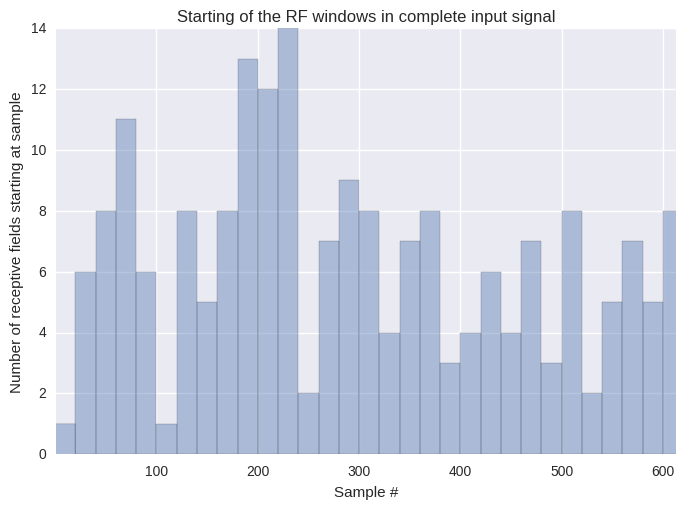

In [61]:
plot_RF_starts(RF_data_22,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

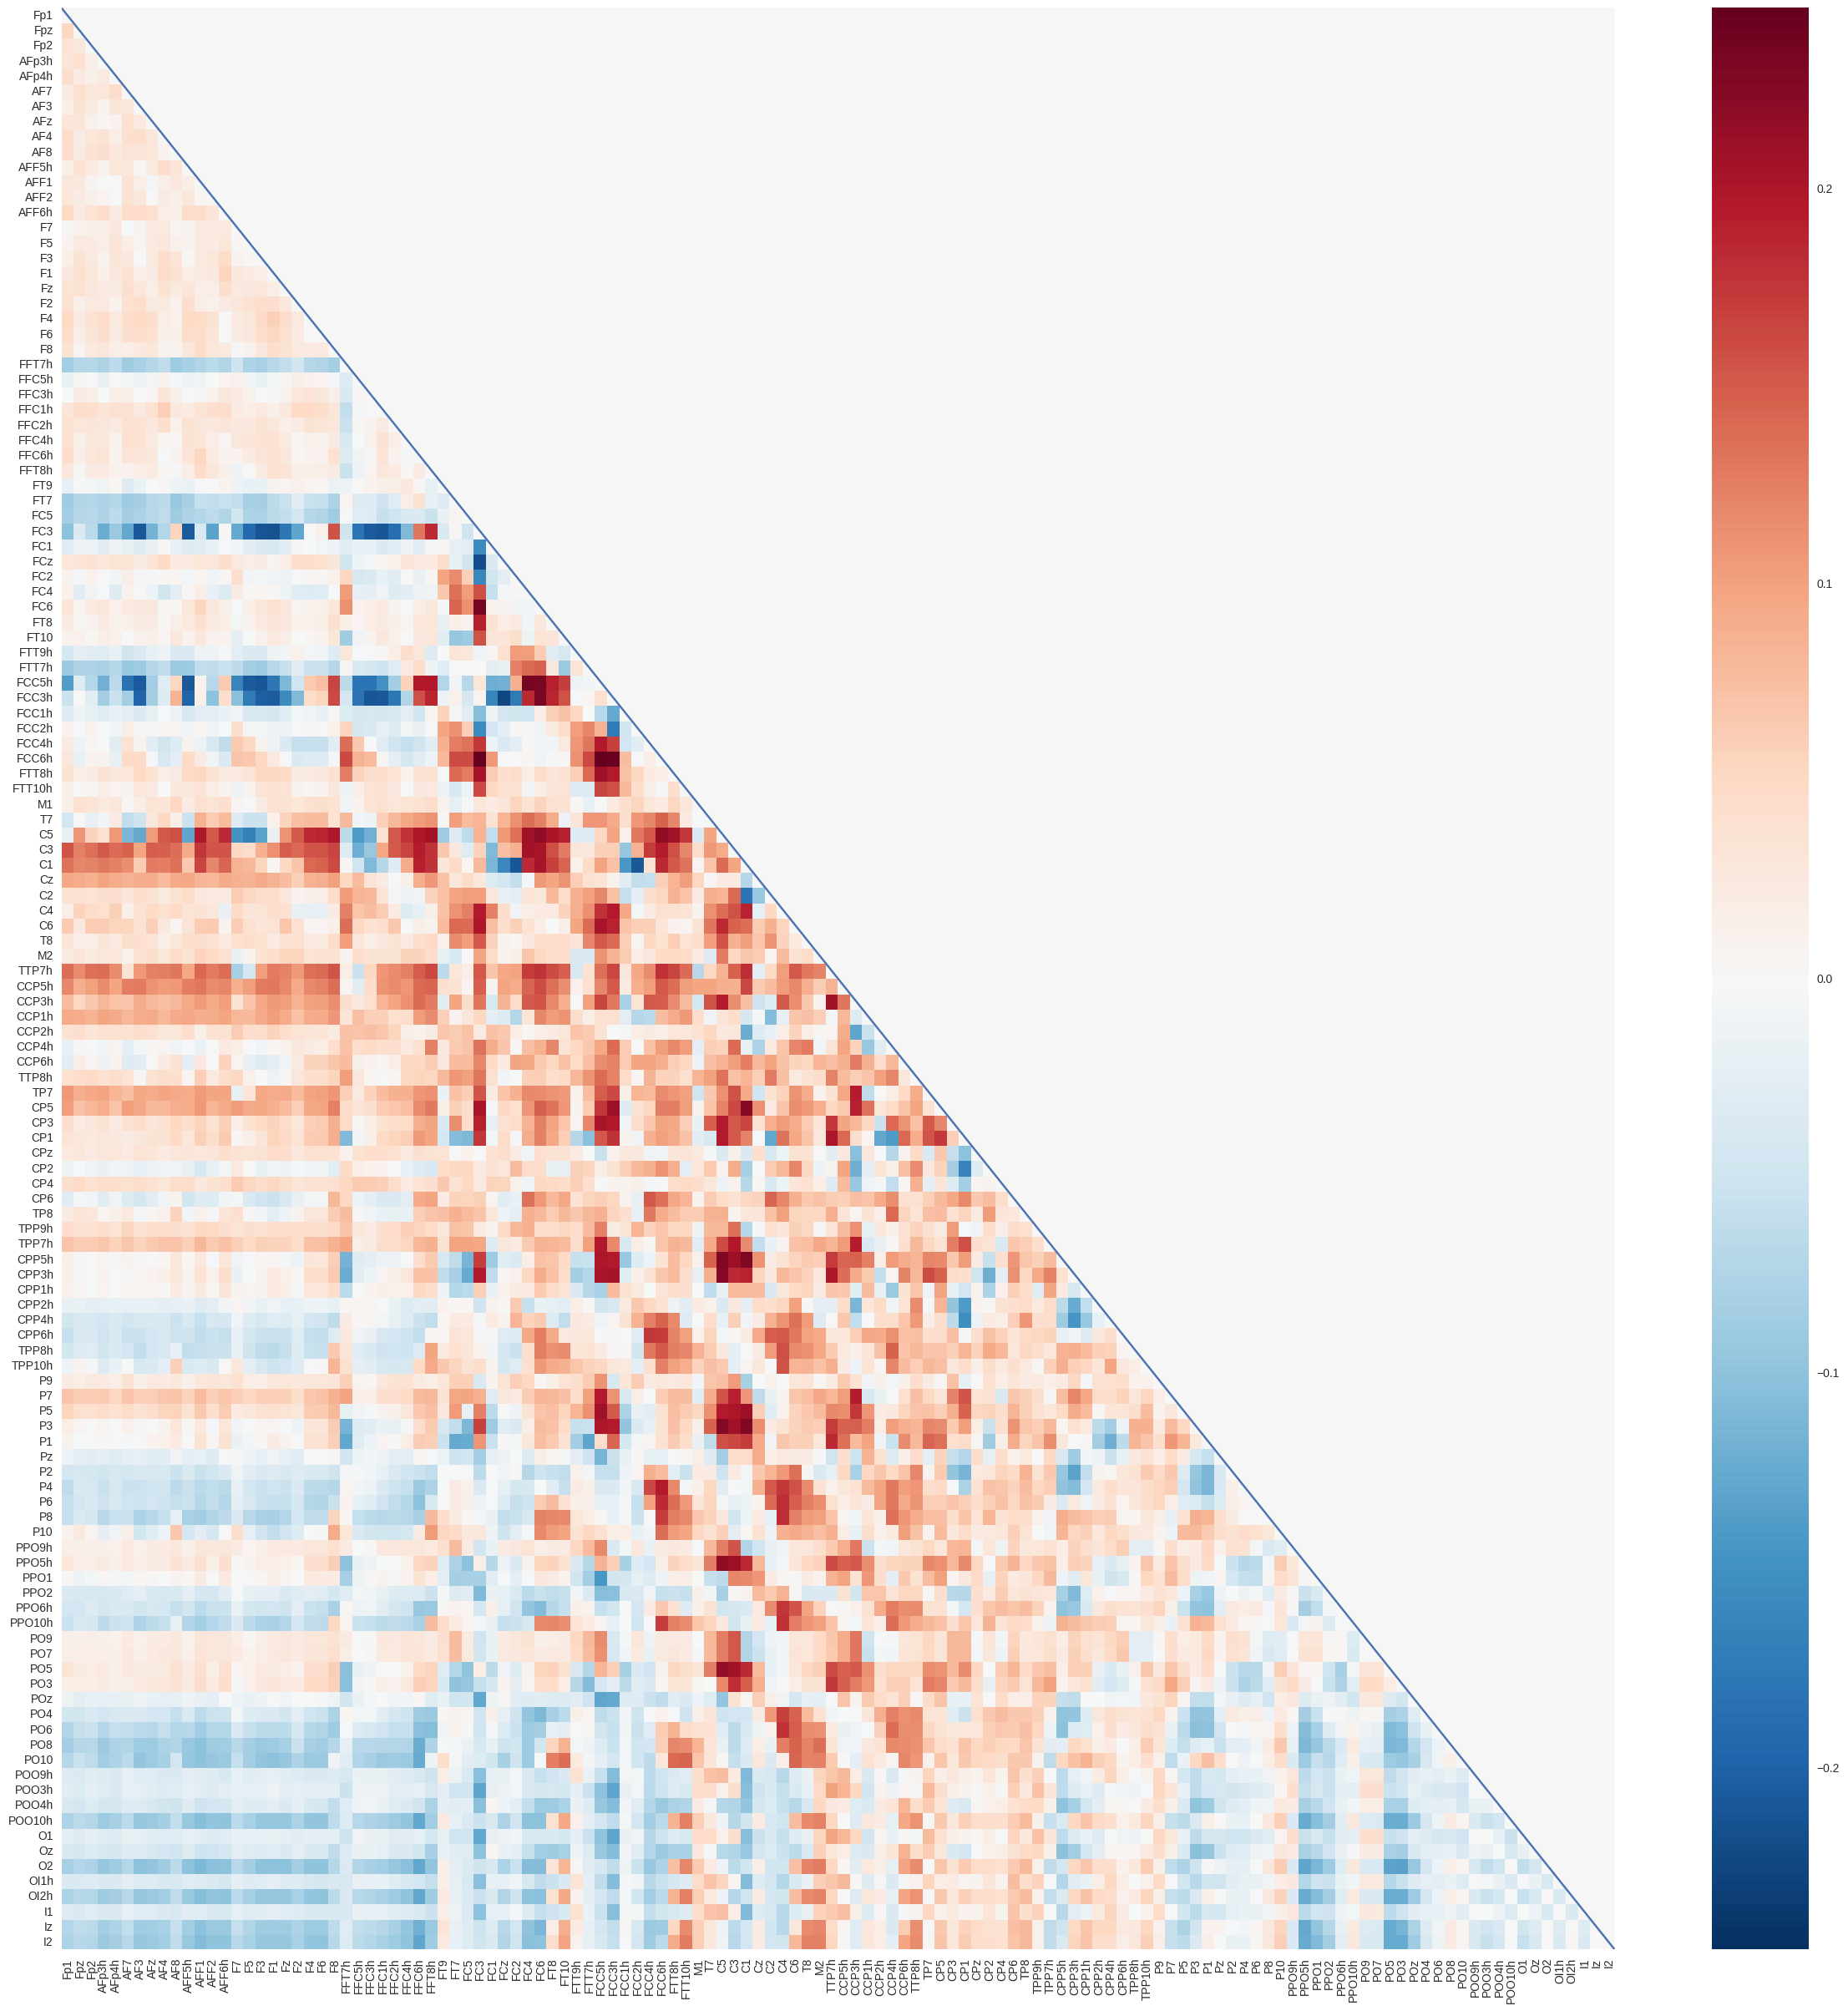

In [62]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [63]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.499653  p 0.000000  : Bandpower CCP5h
Score 0.490546  p 0.000000  : Bandpower C3
Score 0.466032  p 0.000000  : Bandpower CP3
Score 0.444256  p 0.000000  : Bandpower CP5
Score 0.424335  p 0.000000  : Bandpower CCP3h
Score 0.411409  p 0.000000  : Bandpower CPP3h
Score 0.409315  p 0.000000  : FFT CP3 12.2739018088
Score 0.406181  p 0.000000  : FFT CP1 12.2739018088
Score 0.401488  p 0.000000  : FFT C3 10.9819121447
Score 0.399821  p 0.000000  : FFT CPP3h 12.2739018088
Score 0.396260  p 0.000000  : Bandpower C1
Score 0.387738  p 0.000000  : Bandpower CP1
Score 0.381448  p 0.000000  : FFT CCP3h 12.2739018088
Score 0.376052  p 0.000000  : FFT Cz 32.9457364341
Score 0.373264  p 0.000000  : FFT CCP1h 32.9457364341
Score 0.369187  p 0.000000  : FFT C4 22.6098191214
Score 0.367440  p 0.000000  : FFT C2 11.6279069767
Score 0.367113  p 0.000000  : FFT CP5 10.9819121447
Score 0.367024  p 0.000000  : FFT C1 20.6718346253
Score 0.363323  p 0.000000  : FFT C3 31.65374677


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

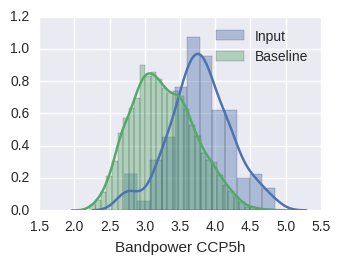

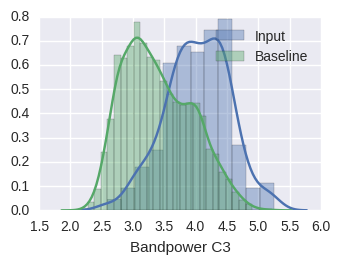

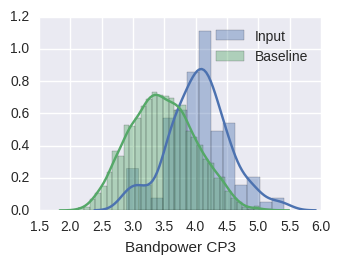

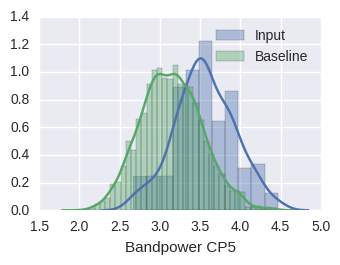

In [64]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

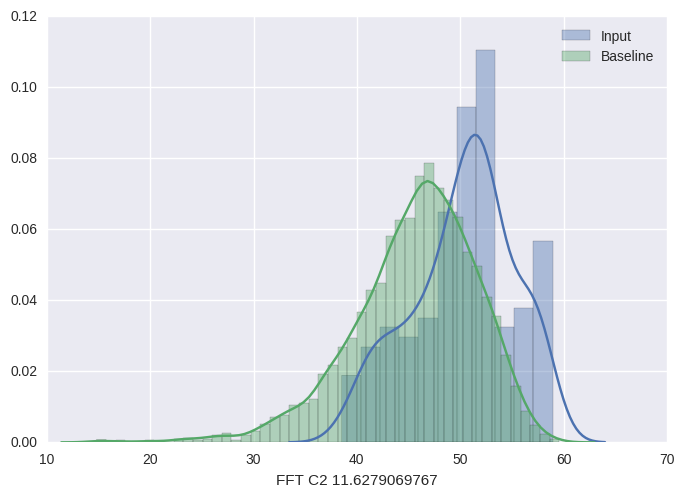

In [65]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[16])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [66]:
print index_labels[sort_mean_diff[:10]]

[['Bandpower', [64]] ['Bandpower', [55]] ['Bandpower', [73]]
 ['Bandpower', [72]] ['Bandpower', [65]] ['Bandpower', [83]]
 ['FFT', [73, 19]] ['FFT', [74, 19]] ['FFT', [55, 17]] ['FFT', [83, 19]]]


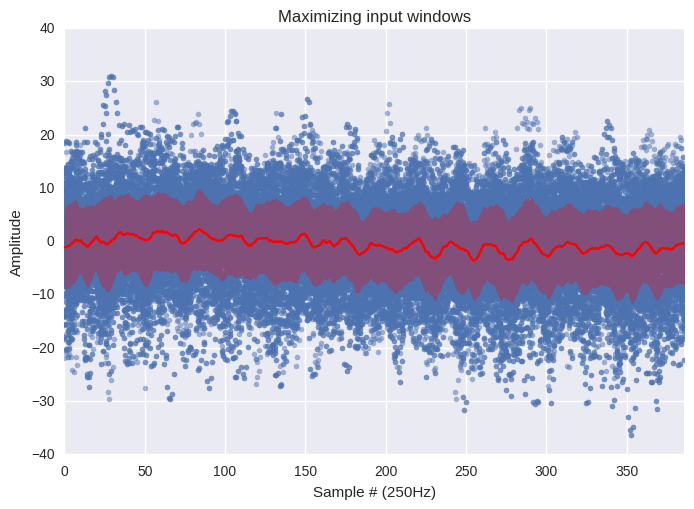

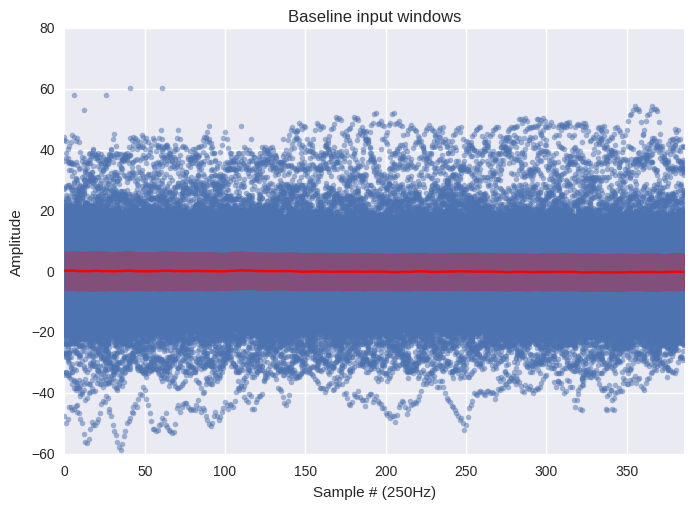

In [24]:
plot_channel_avg(X_RF_cropped,64,'Maximizing input windows')
plot_channel_avg(X_baseline,64,'Baseline input windows')

# Layer 28

Analysis of filters in Layer 28

In [25]:
RF_data_22

<receptive_field.ReceptiveFieldInputsIO instance at 0x7f77ce87bfc8>

In [26]:
filename = 'Layer28_nUnits200_nFilters05_filterdiff_traindata.data'
RF_data_28 = RF_save.load(os.path.join(savepath,modelname,filename))

### Filter activation
Mean activation for each filter in the Layer over all units and inputs of a specific class minus the mean activitaction for the remaining classes.

Activation matrix of size $Filters \times Units \times Inputs \xrightarrow[]{average} Filters$

Max filters are the filters with the highest difference of average activation.

Max filters:  [2 3 0 1]


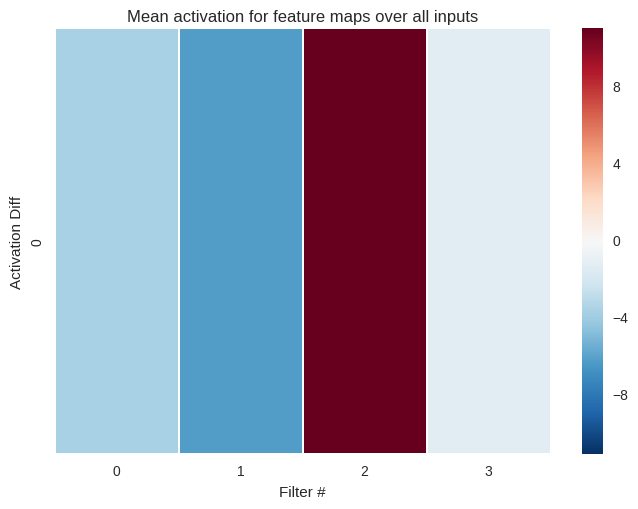

In [70]:
plot_max_filters(RF_data_28)

<b>Filter to look at</b> (index in Max filters)

In [71]:
filt = 0

In [72]:
n_chans = RF_data_28.results[cl].n_chans
sampling_rate = RF_data_28.results[cl].sampling_rate
sensor_names = RF_data_28.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_28,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[sensor_names,frequencies],
                                    'FFTc':[sensor_names,frequencies],
                                    'Phase':[sensor_names,frequencies[1:]],
                                    'Phasec':[sensor_names,frequencies[1:]],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names],
                                    'Bandpower':[sensor_names]})

(1344, 128, 1000, 1)
(4032, 128, 522)
(373, 128, 261) (373, 128) (373, 128, 129) (373, 128)
(4032, 128, 261) (4032, 128) (4032, 128, 129) (4032, 128)


### Receptive field starting sample
Sample at which the receptive field started in the original input.  
The original input window has a length of 4 seconds containing 1000 samples (250 Hz).  
Interesting to see if the maximizing signal windows for that filter are evenly distributed over the whole trial or e.g. accumulate in the middle of the trial.

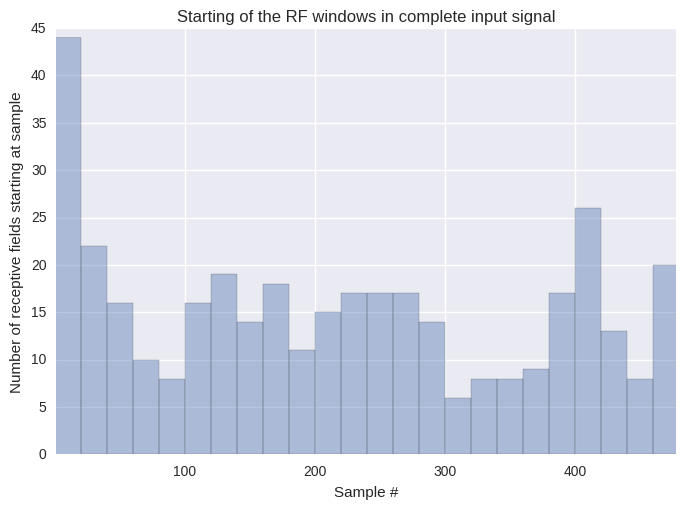

In [73]:
plot_RF_starts(RF_data_28,X_baseline.shape[2])

### Phase locking of channels
Phase locking of channel pairs. Phase locking is computed for class signals and baseline signals. The plot shows the difference PL_class-PL_baseline. The Phase locking value is averaged over the complete windows. So an average Phase locking for all inputs and time steps is computed.
http://www.ncbi.nlm.nih.gov/pubmed/10619414

The Phase Lock Values are computed for the band 8-15 Hz

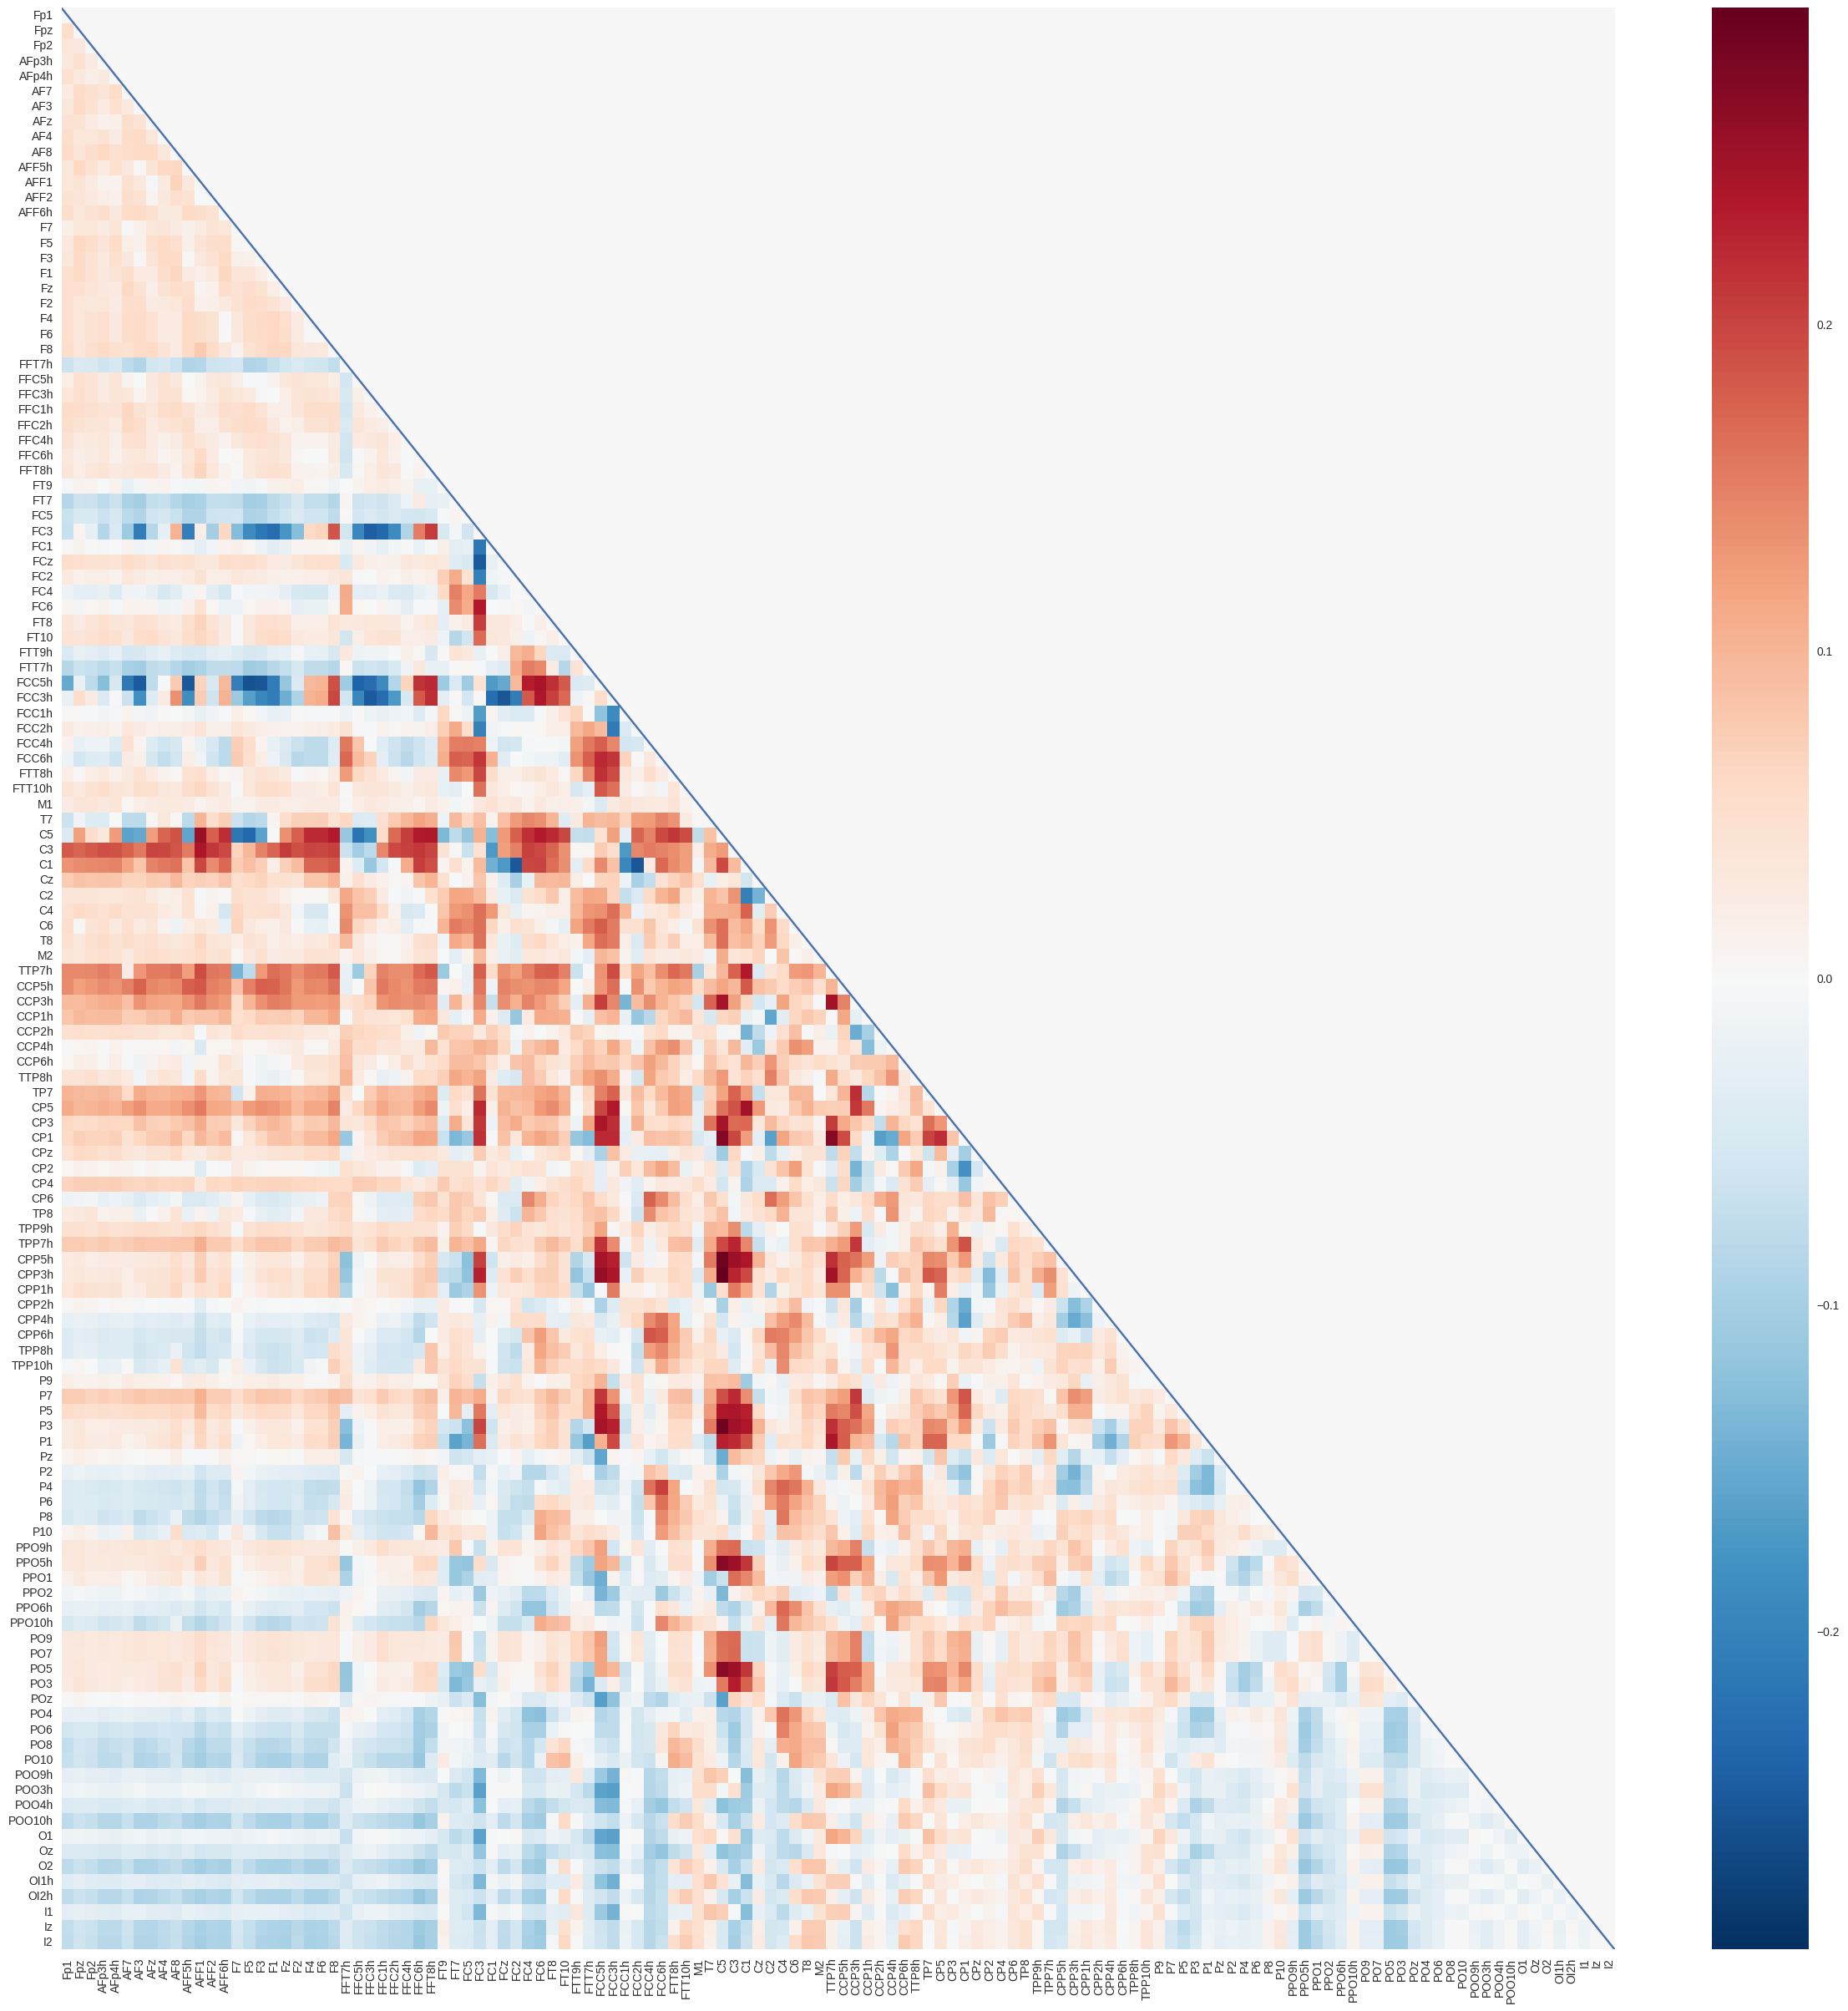

In [74]:
phaselock_class = analysis.phase_locking_value(X_RF_cropped, sampling_rate, 100, [8, 15])
phaselock_base = analysis.phase_locking_value(X_baseline, sampling_rate, 100, [8, 15])
plot_phaselocks(phaselock_class-phaselock_base,sensor_names)

### Most differentiating Features
Features that are most distinct between the maximizing signal windows and baseline windows of the same size that were randomly sampled from inputs of the 3 other classes, but <b>starting at the same time samples during the trials</b> as the maximizing windows. This is done to get a better baseline for filters that appear to be time specific.

<b>Score is calculated by</b> the Kolmogorov–Smirnov test
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test  
<b>0</b>: Complete overlap of distributions <b>1</b>: No overlap

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [75]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.567955  p 0.000000  : Bandpower C3
Score 0.563761  p 0.000000  : Bandpower CCP5h
Score 0.508324  p 0.000000  : Bandpower CP3
Score 0.481598  p 0.000000  : Bandpower CP5
Score 0.453087  p 0.000000  : Bandpower CCP3h
Score 0.447961  p 0.000000  : FFT CCP5h 11.0153256705
Score 0.444478  p 0.000000  : FFT C3 11.0153256705
Score 0.425167  p 0.000000  : Bandpower CPP3h
Score 0.424753  p 0.000000  : Bandpower C1
Score 0.418081  p 0.000000  : FFT CCP3h 11.0153256705
Score 0.409117  p 0.000000  : Bandpower CP1
Score 0.406837  p 0.000000  : FFT CP5 11.0153256705
Score 0.397388  p 0.000000  : FFT C3 10.5363984674
Score 0.396255  p 0.000000  : FFT CP3 11.0153256705
Score 0.384964  p 0.000000  : FFT CCP3h 10.5363984674
Score 0.379874  p 0.000000  : FFT CP3 11.9731800766
Score 0.367911  p 0.000000  : FFT CCP3h 11.9731800766
Score 0.364522  p 0.000000  : Bandpower C2
Score 0.363611  p 0.000000  : FFT CCP3h 10.0574712644
Score 0.362525  p 0.000000  : Bandpower FCC3h


##### Feature distributions
Distributions of the 5 highest scoring features for maximizing and baseline signal windows.
Blue shows the maximizing and green the baseline windows

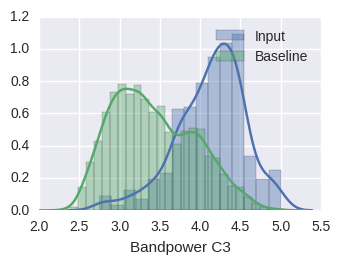

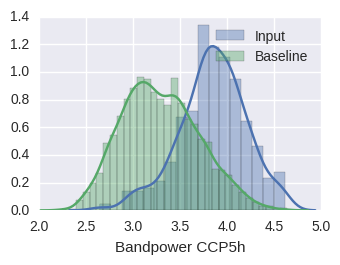

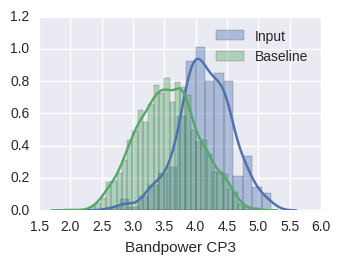

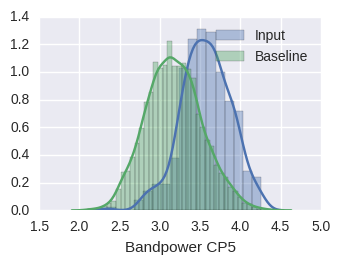

In [76]:
subplots_4_features(features_class,features_base,sort_mean_diff[:4])

<b>Plots to investigate a specific feature</b>

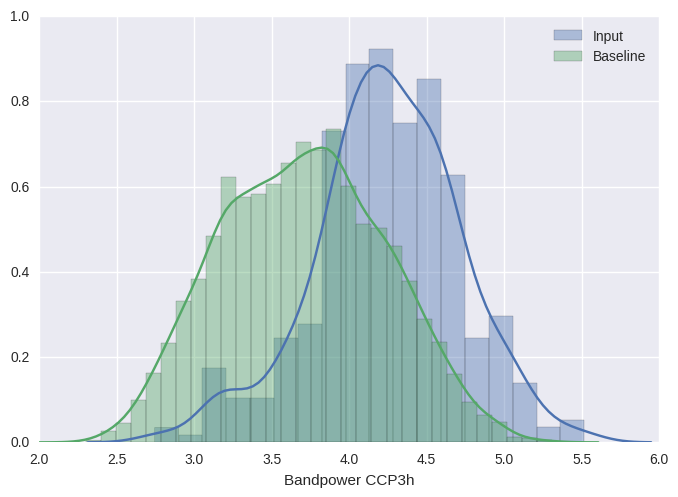

In [77]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[4])

### Average signal window
Average of the 20 maximizing signal windows and baseline windows for a specific channel (e.g. channel from highest scoring feature).  
The red curve is the average with 1 std confidence interval. Blue dots are the original values at that time sample.

In [78]:
print index_labels[sort_mean_diff[:10]]

[['Bandpower', [55]] ['Bandpower', [64]] ['Bandpower', [73]]
 ['Bandpower', [72]] ['Bandpower', [65]] ['FFT', [64, 23]]
 ['FFT', [55, 23]] ['Bandpower', [83]] ['Bandpower', [56]]
 ['FFT', [65, 23]]]


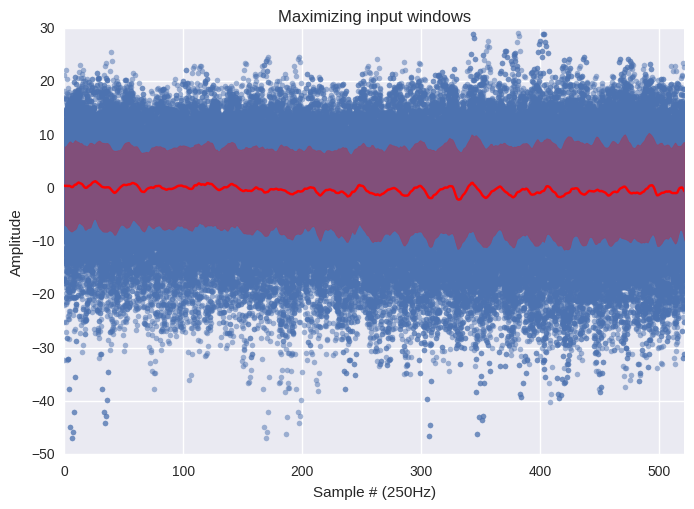

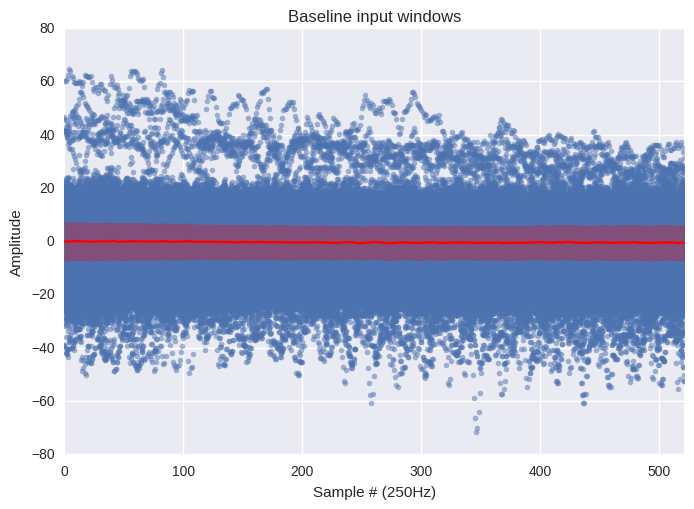

In [79]:
plot_channel_avg(X_RF_cropped,55,'Maximizing input windows')
plot_channel_avg(X_baseline,55,'Baseline input windows')